# Projekt

Uniwersytet Ekonomiczny we Wrocławiu.
DATA SCIENCE - Zaawansowana analiza danych.

$Paweł~Tometczak$

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

W projekcie przeanalizowano dane dotyczące przedsiębiorstwa $XXX$ sprzedajacego produkty różnego rodzaju. Poddano analizie wartość dokonanych zakupów w kolejnych latach - podział na płeć, sprzedaż w kontekście analizy zarówno ilościowej, jak i jakościowej, a także popularność miast sprzedaży i poszczególne produkty, pod kątem ich udziału zarówno w wielkości sprzedaży, jak i w przychodach przedsiębiorstwa. Określono sezonowość sprzedaż w poszczególnych latach w rozłożeniu na miesiące.
Pierwsza część projektu to wczytanie danych i ich obróbka w celu daleszej analizy. Kolene dwie części skupiają się na podstawowych statystykach zbioru danych. Część czwarta obejmuje testy statystyczne dotyczące zbioru danych. Analiza koszykowa, która znajduje się w części piątej projektu, opisuje i przedstawia możliwości zrozwoju strategii ekonomicznych w przedsiębiorstwie, dotyczące kampani sprzedażowych. Ostatnia część projektu to analiza szeregów czasowych z wykorzystaniem modelu $ARIMA$ i alborytmu $XGBoost$.

Zaczynamy od wczytania potrzebnych pakietów i bibliotek:

In [28]:
ls "/content/drive/My Drive/Pawel_Tometczak_UE_DS_end"

customers.txt     orders.txt                       style-notebook.css
data-science.jpg  Pawel_Tometczak_UE_DS_end.ipynb  style-table.css
orderlines.txt    products.txt


In [29]:
cd"/content/drive/My Drive/Pawel_Tometczak_UE_DS_end"

/content/drive/My Drive/Pawel_Tometczak_UE_DS_end


In [0]:

#!pip install qgrid
#! pip install --upgrade git+https://github.com/statsmodels/statsmodels
#!pip install qgrid

In [0]:
#import bibliotek wkorzystaych w projekcie
import numpy as np
import pandas as pd
from pandas import DataFrame
import qgrid

#biblioteki należy zainstalować - ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import tsa


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
register_matplotlib_converters()
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

from mlxtend.frequent_patterns import apriori, association_rules

import scipy.stats
from scipy.stats import kstest
from scipy import stats
from scipy.stats import skew

import random

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [0]:
#! pip install --upgrade statsmodels to import the STL class.statsmodels.org/stable/release/version0.11.html

In [0]:
#definicja stylu wyświetlania tabel i nagłówków
##from IPython.core.display import HTML
#css = open('style-table.css').read() + open('style-notebook.css').read()
#HTML('<style>{}</style>'.format(css))

In [0]:
# parametryzacja matplotlib
%matplotlib inline
# seaborn jako domyślny styl wykresów
sns.set()  
# włączenie wyświetlania wszystkich kolumn dataframe'ów
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# ustalenie precyzji wyświetlania liczb do 2 miejsc po przecinku
pd.set_option('float_format', '{:.2f}'.format)

## Wczytanie danych i oczyszczenie, normalizacja tabel dla wygodniejszej dalszej pracy.

In [0]:
#wczytanie danych z pliku products.txt i ustawienie indexu na kolumnie  'PRODUCTID'
products_raw = pd.read_csv("products.txt", sep ='\t', engine='python', index_col = 'PRODUCTID')

# ujednolicenie wielkości liter
products_raw.columns = products_raw.columns.str.lower()
products_raw.index.name = products_raw.index.name.lower()

#wczytanie danych z pliku customers.txt i ustawienie indexu na kolumnie  'customerid'
customers_raw = pd.read_csv("customers.txt", sep ='\t', engine ='python', index_col = 'customerid')

#wczytanie danych z pliku orders.txt i konwertuj typ orderdate na datetime
orders_raw = pd.read_csv("orders.txt", encoding ='cp1251', sep ='\t', engine='python')
orders_raw.orderdate = pd.to_datetime(orders_raw.orderdate)

#wczytanie danych z pliku orderlines.txt i ustawienie indexu na kolumnie  'orderlineid'
#konwertuj typ shipdate i billdate na datetime, dodaję kolumnę z rokiem
orderlines_raw = pd.read_csv("orderlines.txt",delimiter ="\t", encoding="cp1251",  index_col = 'orderlineid')
orderlines_raw.shipdate = pd.to_datetime(orderlines_raw.shipdate)
orderlines_raw.billdate = pd.to_datetime(orderlines_raw.billdate)
orderlines_raw['year'] = orderlines_raw.shipdate.dt.year

#zmienne do stworzenia zbioru BigData
products_raw_bd = products_raw.reset_index()
customers_raw_bd = customers_raw.reset_index()
orders_raw_bd = orders_raw

#łączę tabele orders_raw i customers_raw, klucz - 'customerid', metoda - 'outer'
#rezultatem będzie tabela ze wszystkich danych obu tabel, a tam gdzie brakuje wartości jest NaN
BigData = pd.merge(orders_raw_bd, customers_raw_bd, on ='customerid', how='outer')

In [36]:
# połączenie dataframe products i orderline. Metoda łączenia: INNER JOIN i klucz: 'productid'
orderlines_raw_bd = pd.read_csv("orderlines.txt",delimiter ="\t", encoding="cp1251")
little_data = pd.merge(orderlines_raw_bd, products_raw_bd, on ='productid', how ='inner')

# ujednolicenie wielkości liter w nazwach kolumn zbiorów produktów i pozycji zamówień
products_raw_bd.columns = map(str.lower, products_raw_bd.columns)

#połączenie zbiorów do wygenerowania tabel
BigData = pd.merge(little_data, BigData, on ='orderid', how='inner')
differenc_table = BigData.numorderlines != BigData.numunits_y


BigData[differenc_table].head(3)

,orderlineid,orderid,productid,shipdate,billdate,unitprice,numunits_x,totalprice_x,productname,productgroupcode,productgroupname,instockflag,fullprice,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice_y,numorderlines,numunits_y,householdid,gender,firstname
9,1010628,1010318,10834,2010-12-09 00:00:00,2010-12-10 00:00:00,25.00,2,50.00,nan,BK,BOOK,N,25,35809,2141,2010-12-01,HONOLULU,HI,96816,AE,80.00,3,4,20327232.00,F,LINDA
10,1010664,1010318,10930,2010-12-09 00:00:00,2010-12-10 00:00:00,16.00,1,16.00,nan,BK,BOOK,N,16,35809,2141,2010-12-01,HONOLULU,HI,96816,AE,80.00,3,4,20327232.00,F,LINDA
11,1010663,1010318,11176,2010-12-09 00:00:00,2010-12-10 00:00:00,14.00,1,14.00,nan,BK,BOOK,N,16,35809,2141,2010-12-01,HONOLULU,HI,96816,AE,80.00,3,4,20327232.00,F,LINDA


In [37]:
#dodanie kolumn z miesiącami i latami i kwartałami
BigData['year'] = BigData['orderdate'].dt.year
BigData['month'] = BigData['orderdate'].dt.month
BigData['quarter'] = (np.ceil(BigData['month']/3)).astype(int)
BigData.head(2)

,orderlineid,orderid,productid,shipdate,billdate,unitprice,numunits_x,totalprice_x,productname,productgroupcode,productgroupname,instockflag,fullprice,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice_y,numorderlines,numunits_y,householdid,gender,firstname,year,month,quarter
0,1010561,1006414,10834,2011-03-07 00:00:00,2011-03-08 00:00:00,18.00,1,18.00,nan,BK,BOOK,N,25,48167,2141,2011-01-18,BURMINGHAM,AL,35222,MC,36.00,2,2,18335614.00,M,LAWRENCE,2011,1,1
1,1010560,1006414,10842,2011-01-19 00:00:00,2011-01-20 00:00:00,18.00,1,18.00,nan,BK,BOOK,N,20,48167,2141,2011-01-18,BURMINGHAM,AL,35222,MC,36.00,2,2,18335614.00,M,LAWRENCE,2011,1,1


In [0]:
# funkcja DFSTATS(df) generuje podsumowanie statystyk poszczególnych kolumn zadanej ramki
def dfstats(df):
    summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
    summary['rows'] = pd.DataFrame(df.isnull().sum()+df.notnull().sum())
    summary['unique_values'] = pd.DataFrame(df.nunique())
    summary['if_nulls'] = pd.DataFrame(df.isnull().any())
    summary['num_nulls'] = pd.DataFrame(df.isnull().sum())
    summary['pct_nulls'] = round((df.apply(pd.isnull).mean()*100),2)
    summary.Dtype = summary.Dtype.astype(str)
    return summary

In [39]:
#sprawdzam jakiego typu zmienne występują w zbiorze
#zmienne całkowite,zmiennoprzecinkowe, kategoryczne porządkowe, kategoryczne nominalne, zmienne typu logicznego, daty)
#sprawdzam ile jest unikalnych wartości oraz występowanie braków danych

# użycie funkcji def dfstats i biblioteki Qgrid z celu praktyczniejszego wyświetlania tabeli

dfstats_BigData_qgrid = dfstats(BigData)
BigData_2 = qgrid.show_grid(dfstats_BigData_qgrid)
BigData_2

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [40]:
#podstawowe statystyki zbioru BigData
BigData.describe()

,orderlineid,orderid,productid,unitprice,numunits_x,totalprice_x,productname,fullprice,customerid,campaignid,totalprice_y,numorderlines,numunits_y,householdid,year,month,quarter
count,286017.00,286017.00,286017.00,281033.00,286017.00,286017.00,0.00,286017.00,286017.00,286017.00,286017.00,286017.00,286017.00,280853.00,286017.00,286017.00,286017.00
mean,1263250.72,1177575.02,11715.23,46.28,1.52,47.93,nan,59.13,94674.04,2171.54,114.63,2.53,19.50,31205078.31,2013.16,7.66,2.84
std,263224.67,164557.25,989.71,105.62,14.69,109.55,nan,160.92,56328.38,51.97,406.54,5.57,487.56,13133709.03,1.90,3.77,1.18
min,1000001.00,999992.00,10001.00,0.00,0.00,0.00,nan,0.00,0.00,2001.00,0.00,1.00,1.00,18111489.00,2009.00,1.00,1.00
25%,1071505.00,1055595.00,11014.00,10.00,1.00,10.05,nan,14.00,45933.00,2141.00,18.00,1.00,1.00,19885296.00,2012.00,5.00,2.00
50%,1143009.00,1109353.00,11179.00,17.50,1.00,18.00,nan,24.00,94074.00,2173.00,29.95,2.00,2.00,23509782.00,2014.00,8.00,3.00
75%,1408147.00,1263197.00,12719.00,27.31,1.00,30.00,nan,33.00,144078.00,2236.00,69.95,3.00,3.00,36213864.00,2015.00,11.00,4.00
max,2017159.00,1643157.00,14040.00,6250.00,3000.00,6780.00,nan,6250.00,189559.00,2239.00,9848.96,150.00,19527.00,81810420.00,2016.00,12.00,4.00


In [41]:
#sprawdzam liczności zmiennych kategorycznych 
for col in BigData.select_dtypes(['object', 'category']):
    print(BigData[col].value_counts())

2015-05-27 00:00:00    1630
2014-12-16 00:00:00    1533
2014-12-10 00:00:00    1519
2015-12-13 00:00:00    1518
2014-12-19 00:00:00    1423
                       ... 
2010-06-19 00:00:00       1
2013-02-23 00:00:00       1
2014-07-26 00:00:00       1
2010-03-08 00:00:00       1
2014-05-03 00:00:00       1
Name: shipdate, Length: 1887, dtype: int64
2015-05-28 00:00:00    1575
2014-12-11 00:00:00    1521
2014-12-12 00:00:00    1452
2011-02-16 00:00:00    1410
2010-11-25 00:00:00    1270
                       ... 
2010-03-09 00:00:00       1
2011-01-09 00:00:00       1
2014-08-24 00:00:00       1
2013-01-28 00:00:00       1
2014-04-13 00:00:00       1
Name: billdate, Length: 1901, dtype: int64
BK    113210
AR     56498
OC     41713
FR     28073
GA     18469
AP     12348
CA      9872
OT      5825
#N         9
Name: productgroupcode, dtype: int64
BOOK        113210
ARTWORK      56498
OCCASION     41713
FREEBIE      28073
GAME         18469
APPAREL      12348
CALENDAR      9872
OTHER      

### Wyznaczam współczynniki skośności poszczególnych zmiennych numerycznych.

$$\Large {współczynnik}~{skośności} = 3 * \frac{średnia - mediana}{odchylenie~standardowe}$$

Współczynnik o wartości $0$, to rozkład symetryczny.
Współczynnik o wartości ujemnej to rozkład lewostronnie skośny (wydłużone lewe ramię rozkładu; średnia mniejsza od mediany).
Współczynnik o wartości dodatniej to rozkład prawostronnie skośny (wydłużone prawe ramię rozkładu; średniej większa od mediany).

In [42]:
#skośność rozkładów, oczywiście interesują mnie zmienne numeryczne, które pozwolą na analizę
BigData.skew()

orderlineid      1.19
orderid          1.13
productid        0.45
unitprice        8.94
numunits_x      91.85
totalprice_x     9.87
productname       nan
fullprice       13.13
customerid      -0.03
campaignid      -0.54
totalprice_y    12.41
numorderlines   17.51
numunits_y      32.37
householdid      0.88
year            -0.48
month           -0.40
quarter         -0.42
dtype: float64

### Obserwacje odstające
Zgodnie z regułą, obserwacją odstającą jest obserwacja, która przyjmuje wartość:
Większą niż półtora odstępu międzykwartylowego $(Q3 – Q1)$, od trzeciego kwartyla$(Q3)$.
Mniejszą niż półtora odstępu międzykwartylowego $(Q3 – Q1)$, od pierwszego kwartyla$(Q1)$.

In [43]:
#sprawdzam gdzie występują wartości odstające
Q_first = BigData.quantile(0.25)
Q_third = BigData.quantile(0.75)
iqr = Q_third-Q_first
low_boundary = (Q_first - 1.5 * iqr)
upp_boundary = (Q_third + 1.5 * iqr)
num_of_outliers_L = (BigData[iqr.index] < low_boundary).sum()
num_of_outliers_U = (BigData[iqr.index] > upp_boundary).sum()
outliers = pd.DataFrame({'niska_granica':low_boundary, 'wysoka_granica':upp_boundary,\
                         'wartosci_odstajace_L':num_of_outliers_L, 'wartosci_odstajace_U':num_of_outliers_U}) 

outliers

,niska_granica,wysoka_granica,wartosci_odstajace_L,wartosci_odstajace_U
orderlineid,566542.00,1913110.00,0,8763
orderid,744192.00,1574600.00,0,9580
productid,8456.50,15276.50,0,0
unitprice,-15.96,53.27,0,38744
numunits_x,1.00,1.00,4984,19920
totalprice_x,-19.87,59.92,0,40540
productname,nan,nan,0,0
fullprice,-14.50,61.50,0,40996
customerid,-101284.50,291295.50,0,0
campaignid,1998.50,2378.50,0,0


### Dane klientów

In [44]:
#customers_raw - czyszczenie danych
customers_raw.head()

,householdid,gender,firstname
customerid,,,
174596,53949999,M,DANIEL
68239,49927024,M,JIM
10203,20914414,F,DONNA
174288,53957047,F,DIONE
68099,49927024,M,JIM


In [45]:
dfstats(customers_raw)

,Dtype,rows,unique_values,if_nulls,num_nulls,pct_nulls
householdid,int64,189559,156258,False,0,0.00
gender,object,189559,2,True,16204,8.55
firstname,object,189559,10145,True,2915,1.54


In [46]:
#customers zmienna ostateczna zbioru customers.txt
customers = customers_raw.dropna()
customers.head()

,householdid,gender,firstname
customerid,,,
174596,53949999,M,DANIEL
68239,49927024,M,JIM
10203,20914414,F,DONNA
174288,53957047,F,DIONE
68099,49927024,M,JIM


### Dane o produktach

In [47]:
#products_raw sprawdzanie i  czyszczenie danych po wybraniu kolumn
products_raw.head()

,productname,productgroupcode,productgroupname,instockflag,fullprice
productid,,,,,
10001,nan,CA,CALENDAR,N,15
10002,nan,CA,CALENDAR,N,10
10003,nan,CA,CALENDAR,N,10
10004,nan,BK,BOOK,Y,90
10005,nan,BK,BOOK,Y,16


In [48]:
dfstats(products_raw)

,Dtype,rows,unique_values,if_nulls,num_nulls,pct_nulls
productname,float64,4040,0,True,4040,100.00
productgroupcode,object,4040,9,False,0,0.00
productgroupname,object,4040,8,True,1,0.02
instockflag,object,4040,2,False,0,0.00
fullprice,int64,4040,305,False,0,0.00


In [49]:
#sprawdzam jakie kolumny zawiera Data Frame
products_raw.columns

Index(['productname', 'productgroupcode', 'productgroupname', 'instockflag', 'fullprice'], dtype='object')

In [50]:
#wybieram interesujące mnie kolumny, kolumna productname ma 100% braków i zostaje pominięta
products_df = products_raw[['productgroupcode','productgroupname', 'fullprice']]
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 10001 to 14040
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   productgroupcode  4040 non-null   object
 1   productgroupname  4039 non-null   object
 2   fullprice         4040 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 126.2+ KB


In [51]:
#products_df zmienna ostateczna zbioru products.txt
products_df.head()

,productgroupcode,productgroupname,fullprice
productid,,,
10001,CA,CALENDAR,15
10002,CA,CALENDAR,10
10003,CA,CALENDAR,10
10004,BK,BOOK,90
10005,BK,BOOK,16


### Dane o zamówieniach

In [52]:
# orders_raw- czyszczenie danych
orders_raw.head()

,orderid,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits
0,1002854,45978,2141,2009-10-13,NEWTON,MA,02459,VI,190.00,3,3
1,1002855,125381,2173,2009-10-13,NEW ROCHELLE,NY,10804,VI,10.00,1,1
2,1002856,103122,2141,2011-06-02,MIAMI,FL,33137,AE,35.22,2,2
3,1002857,130980,2173,2009-10-14,E RUTHERFORD,NJ,07073,AE,10.00,1,1
4,1002886,48553,2141,2010-11-19,BALTIMORE,MD,21218,VI,10.00,1,1


In [53]:
dfstats(orders_raw)

,Dtype,rows,unique_values,if_nulls,num_nulls,pct_nulls
orderid,int64,192983,192983,False,0,0.00
customerid,int64,192983,189560,False,0,0.00
campaignid,int64,192983,239,False,0,0.00
orderdate,datetime64[ns],192983,2541,False,0,0.00
city,object,192983,12822,True,19,0.01
state,object,192983,91,True,1119,0.58
zipcode,object,192983,15593,True,146,0.08
paymenttype,object,192983,6,False,0,0.00
totalprice,float64,192983,7653,False,0,0.00
numorderlines,int64,192983,41,False,0,0.00


In [54]:
#procentowa znikomość niepełnych danych, funkcja dropna
#orders ostateczna zmienna orders.txt
orders = orders_raw.dropna()
orders.head()

,orderid,customerid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits
0,1002854,45978,2141,2009-10-13,NEWTON,MA,02459,VI,190.00,3,3
1,1002855,125381,2173,2009-10-13,NEW ROCHELLE,NY,10804,VI,10.00,1,1
2,1002856,103122,2141,2011-06-02,MIAMI,FL,33137,AE,35.22,2,2
3,1002857,130980,2173,2009-10-14,E RUTHERFORD,NJ,07073,AE,10.00,1,1
4,1002886,48553,2141,2010-11-19,BALTIMORE,MD,21218,VI,10.00,1,1


In [55]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191846 entries, 0 to 192982
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   orderid        191846 non-null  int64         
 1   customerid     191846 non-null  int64         
 2   campaignid     191846 non-null  int64         
 3   orderdate      191846 non-null  datetime64[ns]
 4   city           191846 non-null  object        
 5   state          191846 non-null  object        
 6   zipcode        191846 non-null  object        
 7   paymenttype    191846 non-null  object        
 8   totalprice     191846 non-null  float64       
 9   numorderlines  191846 non-null  int64         
 10  numunits       191846 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 17.6+ MB


### Dane o liście zamówień 

In [56]:
orderlines_raw.head()

,orderid,productid,shipdate,billdate,unitprice,numunits,totalprice,year
orderlineid,,,,,,,,
1010561,1006414,10834,2011-03-07,2011-03-08,18.00,1,18.00,2011
1010562,1006541,11052,2011-01-19,2011-01-20,10.00,2,20.00,2011
1010563,1006542,11070,2011-01-19,2011-01-20,19.12,1,19.12,2011
1010564,1010154,11196,2009-11-19,2009-11-20,14.95,1,14.95,2009
1010565,1009110,11048,2009-11-11,2009-11-12,10.00,2,20.00,2009


In [57]:
dfstats(orderlines_raw)

,Dtype,rows,unique_values,if_nulls,num_nulls,pct_nulls
orderid,int64,286017,192983,False,0,0.00
productid,int64,286017,4040,False,0,0.00
shipdate,datetime64[ns],286017,1887,False,0,0.00
billdate,datetime64[ns],286017,1901,False,0,0.00
unitprice,float64,286017,3194,True,4984,1.74
numunits,int64,286017,158,False,0,0.00
totalprice,float64,286017,4082,False,0,0.00
year,int64,286017,8,False,0,0.00


In [58]:
#ostateczna zmienna orderlines.txt
orderlines = orderlines_raw.dropna()
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281033 entries, 1010561 to 2017159
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   orderid     281033 non-null  int64         
 1   productid   281033 non-null  int64         
 2   shipdate    281033 non-null  datetime64[ns]
 3   billdate    281033 non-null  datetime64[ns]
 4   unitprice   281033 non-null  float64       
 5   numunits    281033 non-null  int64         
 6   totalprice  281033 non-null  float64       
 7   year        281033 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 19.3 MB


In [59]:
#łączę pliki customers i orders, dodając kolumny dzień, miesiąc, rok, kwartał
customers_and_orders = pd.merge(customers, orders, on ="customerid")

customers_and_orders = customers_and_orders.dropna()
customers_and_orders['day'] = orders['orderdate'].dt.day
customers_and_orders['month'] = orders['orderdate'].dt.month
customers_and_orders['year'] = orders['orderdate'].dt.year
customers_and_orders['quarter']=(np.ceil(customers_and_orders['month']/3))

#zmiana typu zmiennych z kolumn: day, month, year, quarter na liczby całkowite
customers_and_orders = customers_and_orders.dropna()#(error) Cannot convert non-finite values (NA or inf) to integer
customers_and_orders["day"] = customers_and_orders["day"].astype("int64")
customers_and_orders["month"] = customers_and_orders["month"].astype("int64")
customers_and_orders["year"] = customers_and_orders["year"].astype("int64")
customers_and_orders['quarter'] = (np.ceil(customers_and_orders['month']/3)).astype("int64")
customers_and_orders.head(3)

,customerid,householdid,gender,firstname,orderid,campaignid,orderdate,city,state,zipcode,paymenttype,totalprice,numorderlines,numunits,day,month,year,quarter
0,174596,53949999,M,DANIEL,1391159,2204,2015-09-27,MONTVALE,NJ,07645,AE,44.95,1,1,13,10,2009,4
1,68239,49927024,M,JIM,1391160,2237,2015-09-24,NEW YORK,NY,10036,DB,0.00,1,100,13,10,2009,4
2,10203,20914414,F,DONNA,1391161,2141,2015-09-24,HAMILTON TOWNSHIP,NJ,08619,VI,62.05,3,3,2,6,2011,2


In [60]:
dfstats(customers_and_orders)

,Dtype,rows,unique_values,if_nulls,num_nulls,pct_nulls
customerid,int64,172180,172180,False,0,0.00
householdid,int64,172180,142149,False,0,0.00
gender,object,172180,2,False,0,0.00
firstname,object,172180,7501,False,0,0.00
orderid,int64,172180,172180,False,0,0.00
campaignid,int64,172180,237,False,0,0.00
orderdate,datetime64[ns],172180,2541,False,0,0.00
city,object,172180,11341,False,0,0.00
state,object,172180,66,False,0,0.00
zipcode,object,172180,12985,False,0,0.00


## Podstawowe statystyki.

###  Płeć klientów.

Spośród wszystkich klientów przedsiębiorstwa 55,7% stanowią mężczyźni a 44,3% kobiety. 
Dane dotyczące płci klientów zostały przedstawione w postaci wykresu kołowego z zaznaczeniem etykiet danych.

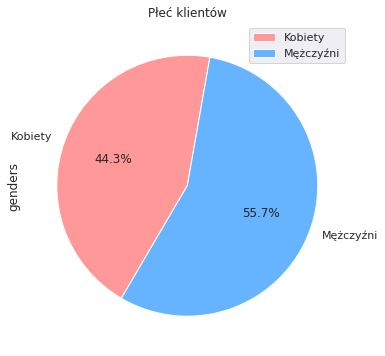

In [61]:
plec = {"Mężczyźni":customers.gender[customers.gender == "M"].count(),"Kobiety": customers.gender[customers.gender == "F"].count()}
plec_df = pd.DataFrame({"genders": plec})
plec_df.plot.pie(subplots=True,  figsize = (6,6),  autopct ='%1.1f%%', colors = ['#ff9999', '#66b3ff'],startangle=80)
_ = plt.title('Płeć klientów')

### Sprzedaż kolejnych latach - podział na płeć

W latach 2009-2011 sprzedaż w firmie $XXX$ wyraźnie rosła. W $2012$ roku sprzedaż była na stałym poziomie i zaczęła podnosić się w latach $2013-2014$. Od roku $2015$ zaobserwowana spadek sprzedaży.
Przez wszystkie lata udział mężczyzn w zakupach był większy niż kobiet.

In [62]:
plot1 = BigData.groupby(['year', 'gender']).sum().loc[2009:2016].totalprice_x
plot1_a = pd.DataFrame(plot1)
sw = plot1_a.reset_index()
sw['gender'].replace({"F": "Kobiety","M": "Męższczyźni",}, inplace=True)
    
fig = px.bar(sw, x = 'year', y = "totalprice_x",color = "gender",\
             color_discrete_sequence = px.colors.qualitative.Pastel)
fig.layout.title = 'Wartość dokonanych zakupów w kolejnych latach - podział na płeć'
fig.layout.xaxis.title = 'Rok'
fig.layout.yaxis.title = 'Sprzedaż'
fig.layout.showlegend = True
#fig.update_layout(legend_title_text = 'Płeć')
fig.layout.showlegend = True
fig.update_layout( barmode = 'group')
fig.show()

### Przychód w kolejnych latach.

Jak można zauważyć rok 2014 to rok gdzie przychód firmy był najwiekszy i do tego roku ta wartość rosła, później następuje spadek.

In [63]:
#przychód w kolejnych latach
year_total_price = orderlines.loc[:, ["year", "totalprice"]].groupby('year').sum().reset_index()
year_total_price.head(8)

,year,totalprice
0,2009,257158.77
1,2010,907805.26
2,2011,1424813.41
3,2012,1396537.58
4,2013,2158385.80
5,2014,2962670.46
6,2015,2776533.76
7,2016,1824991.26


In [64]:
fig = px.line(year_total_price, x = "year", y = "totalprice",color_discrete_sequence=px.colors.qualitative.Pastel)
fig.layout.title = 'Sprzedaż w poszczególnych latach'
fig.layout.xaxis.title = 'Rok'
fig.layout.showlegend = True
fig.show()

### Sprzedaż w kolejnych latach.

Wyraźnie można zaobserwować sezonowość sprzedaży w poszczególnych miesiącah. Szczególnie widoczne to jest w grudniu od $2013$ roku.

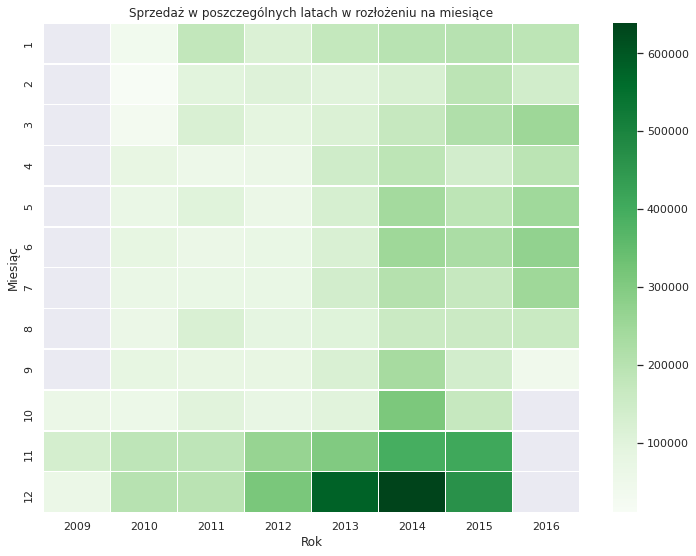

In [65]:
#sprzedaż w poszczególnych latach z podziałem na miesiące
plot2 = BigData.groupby(['year', 'month']).sum().loc[2009:2016].totalprice_x
plot2_a = pd.DataFrame(plot2)
sw2 = plot2_a.reset_index()
sw2 = sw2.pivot("month", "year", "totalprice_x")

f, ax = plt.subplots(figsize = (12, 9))
_=sns.heatmap(sw2, annot = False, linewidths = .5, ax=ax, cmap="Greens")\
.set(title = 'Sprzedaż w poszczególnych latach w rozłożeniu na miesiące',\
ylabel = 'Miesiąc', xlabel = 'Rok')

### Sprzedaż z podziałem na grupy produktów.

In [66]:
#ilość zamówień (grupowanie wg produktu)
select = ["productgroupname","fullprice","numorders"]
orders_a = orderlines_raw.groupby("productid").agg({"orderid" : "nunique"}).rename(columns = {'orderid': 'numorders'})
product_orders = pd.merge(orders_a, products_df, on = "productid")[select]
product_orders.sort_values(by = "numorders")
product_orders = product_orders[product_orders.fullprice != 0]
product_orders.head()

,productgroupname,fullprice,numorders
productid,,,
10001,CALENDAR,15,253
10002,CALENDAR,10,229
10003,CALENDAR,10,168
10004,BOOK,90,34
10005,BOOK,16,1687


In [67]:
#pogrupowanie produktów ze względu na rodzaj i obliczenia odnośnie ceny
product_ordersA = product_orders.groupby("productgroupname").agg({'fullprice': [np.mean, np.std,np.median, np.sum]})
product_ordersA

fullprice                       
                      mean    std median      sum
productgroupname                                 
APPAREL              23.35   9.83     19     2008
ARTWORK             432.70 363.45    340  1427905
BOOK                 40.94 231.35     20     9825
CALENDAR             40.03 109.97     14     1241
GAME                 11.27   9.82      9     2603
OCCASION             24.15  10.64     24     1715
OTHER                29.59  22.00     24     1213

Średnią arytmetyczną ciągu wartości $x_1, \dots, x_n$ nazwyamy:
$$\Large\bar{x}= \frac{x_{1} + x_{2} + \ \ldots \ + x_{n}}{n} = \frac{1}{n} \sum_{i=1}^{n} x_{i}$$  


Medianą ciągu wartości $x_1, \dots, x_n$ nazywamy środkowy wyraz tego ciągu, gdy $n$ jest liczbą nieparzystą, w przeciwnym przypadku średnią arytmetyczną dwóch wyrazów środkowych.

$\Large Mediana = Me = \left\{\begin{array} {lll} x_{(k+1)} &  \hbox{ dla } & n=2k+1 \\[1mm] \frac{x_{(k)}+x_{(k+1)}}{2} & \hbox{ dla } & n=2k. \end{array} \right.$,
gdzie $x_{(1)} \le x_{(2)} \le  \dots \le x_{(n)}.$  


Odchyleniem standardowym ciągu $x_1, \dots, x_n$ nazywamy wartość:

$$\Large s_n = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ( x_{i}-\bar{x})^{2}}$$

In [68]:
#wykres pudełkowy - produkty i cena całkowita
fig = px.box(product_orders,x = "productgroupname", y = "fullprice", color = "productgroupname",
             notched = True,log_y = True, # used notched shape
             title = 'Rozkład ceny całkowitej ze względu na grupę produktów',\
             color_discrete_sequence = px.colors.qualitative.Pastel)

fig.layout.xaxis.title = 'Rodzaj produktu'
fig.layout.yaxis.title = 'Cena całkowita'
fig.layout.showlegend = False
#fig.update_traces(quartilemethod = "exclusive")
#fig.update_layout(legend_title_text = 'Rodzaj produktu')
fig.layout.showlegend = True
fig.show()

In [69]:
# produkty z podziałem na rok
select = ["productid","year","productgroupname"]
product_years = pd.merge(products_df, orderlines, on = "productid")[select].\
groupby(["year","productgroupname"]).agg({"productid" : "count"}) \
.rename(columns = {'productid': 'count'}).sort_values(by = ["year","productgroupname"])

product_years.head()

count
year productgroupname       
2009 APPAREL              15
     ARTWORK            4835
     BOOK               3917
     CALENDAR             15
     OCCASION           1112

In [70]:
#ilość sprzedanych produktów z poszczególnych kategorii na przesrzeni lat
product_years_index = product_years.reset_index()

fig = px.bar(product_years_index, x = 'year', y = "count",\
             color = "productgroupname", color_discrete_sequence = px.colors.qualitative.Pastel)
fig.layout.title = 'Ilość sprzedanych produktów w kolejnych latach'
fig.layout.xaxis.title = 'Lata'
fig.layout.yaxis.title = 'Ilość'
#fig.update_layout(legend_title_text = 'Rodzaj produktu')
fig.layout.showlegend = True
fig.update_layout( barmode='group')
fig.show()

In [71]:
plot_parallel = BigData[['paymenttype', 'productgroupname', 'year']]
plot_parallel['paymenttype'].replace({"VI": "1FirstBank",
                                       "MC": "MC Bank",
                                      "AE": "American Express",
                                      "DB": "Deutsche Bank",
                                      "OC": "Orange County",
                                      "??": 'OTHER'}, inplace=True)

fig = px.parallel_categories(plot_parallel, dimensions=['paymenttype', 'productgroupname', 'year'],\
                             color = 'year', color_continuous_scale=px.colors.sequential.Viridis,
                            labels={'paymenttype':'Rodzaj karty płatniczej', 'productgroupname':'Rodzaj produktu', 'year':'Rok'},\
                            title = 'Zestawienie cech: karty płatnicze - rodzaj produktu - rok zakupu')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Miasta z największym przychodem.

Analiza wykazuje, że  dziesięć, przynoszących nawiększy przychód, miast to: New York, Brooklyn, Chicago, Washington, Los Angeles, San Francisco, Houston, Atlanta, Dallas, Seattle.
Liderem jeat $NEW~YORK$ z przychodem $1~571~296.06$ dolarów.

In [72]:
city_totalprice = orders[['city', 'totalprice']]
city_totalprice_gr = city_totalprice.groupby('city').sum().reset_index()\
.sort_values(by = 'totalprice', ascending=False).head(10)
city_totalprice_gr

,city,totalprice
7249,NEW YORK,1571296.06
1300,BROOKLYN,234760.02
1906,CHICAGO,219478.89
11420,WASHINGTON,206097.78
5815,LOS ANGELES,194014.83
9401,SAN FRANCISCO,144687.92
4678,HOUSTON,137757.62
423,ATLANTA,115784.27
2441,DALLAS,113732.83
9703,SEATTLE,88012.00


In [73]:
fig = px.bar(city_totalprice_gr,x = "city", y = 'totalprice', height = 500, color = 'city',\
             color_discrete_sequence = px.colors.qualitative.Pastel)
#fig.update_layout(legend_title_text = 'Miasto')
fig.layout.xaxis.title = 'Miasto'
fig.layout.yaxis.title = 'Przychód'
fig.show()

### Karty kredytowe - rodzaje używanych kart

In [74]:
#Rodzaj używanej karty płatniczej - podział we względu na płeć
gender_pay_typ = customers_and_orders[["orderid","gender","paymenttype",'year']]
plot_pay_g = gender_pay_typ.groupby(["paymenttype","gender",'year']).agg({"orderid" : "count"})\
.rename(columns={'orderid': 'count'}).sort_values(by = ["paymenttype","gender",'year'])
plot_pay_g_index = plot_pay_g.reset_index()


#z poszukiwań w internecie uzyskałem prawdopodobne nazwy banków oferujące poszczególne karty
plot_pay_g_index['paymenttype'].replace({"VI": "1FirstBank",
                                       "MC": "MC Bank",
                                      "AE": "American Express",
                                      "DB": "Deutsche Bank",
                                      "OC": "Orange County",
                                      "??": 'OTHER'}, inplace=True)

fig = px.bar(plot_pay_g_index, x = "gender", y = "count",color = "paymenttype",\
            color_discrete_sequence = px.colors.qualitative.Pastel)
fig.layout.title = 'Rodzaj używanej karty płatniczej'
fig.layout.xaxis.title = 'Płeć'
fig.layout.yaxis.title = 'Ilość'
#fig.update_layout(legend_title_text='Rodzaje kart kredytowych')
fig.layout.showlegend = True
fig.update_layout( barmode='group')
fig.show()

### Rodzaje płatności i ich udział w zakupach w kolejnych latach

Poddano analizie rodzaje płatności oraz ich udział w zakupach w latach $2009-2016$. Największą popularnością cieszyły się karty $VI$, a najmniejszą $OC$. W stosunku do sumy rodzajów płatności stałym zainteresowaniem cieszą się płatności typu $AE$ oraz $MC$. Płatność lkartą $DB$ była popularna w latach $2009 - 2011$ działalności firmy, poczym zauważenie spadła do $2016$ roku.


In [75]:
#ilość płatności poszczególnymi kartami w latach 2009-2016
fig = px.bar(plot_pay_g_index, x= "year", y="count",color="paymenttype",\
            color_discrete_sequence=px.colors.qualitative.Pastel)
fig.layout.title = 'Rodzaj używanej karty płatniczej w poszcególnych latach'
fig.layout.xaxis.title = 'Lata'
fig.layout.yaxis.title = 'Ilość płatności'
fig.layout.showlegend = True
#fig.update_layout(legend_title_text = 'Rodzaje kart kredytowych')
fig.update_layout( barmode = 'group')
fig.show()

Największą ilość płatności odnotowana kartą $VI - 1FirstBank$.

In [76]:
#Karty kredytowe popularność - tabela
pay_typ = customers_and_orders.groupby('paymenttype').orderid.count().sort_values(ascending=False)
pay_typ_df = pd.DataFrame(pay_typ).reset_index()
pay_typ_df['paymenttype'].replace({"VI": "1FirstBank",
                                       "MC": "MC Bank",
                                      "AE": "American Express",
                                      "DB": "Deutsche Bank",
                                      "OC": "Orange County",
                                      "??": 'OTHER'}, inplace=True)
tabela_karty = pay_typ_df.rename(columns = {'orderid': 'ilość płatności','paymenttype': 'rodzaj karty'})

tabela_karty.groupby('rodzaj karty').head(6)

,rodzaj karty,ilość płatności
0,1FirstBank,68824
1,MC Bank,42564
2,American Express,42379
3,Deutsche Bank,10744
4,Orange County,7402
5,OTHER,267


In [77]:
#popularność kart kredytowych procentowo
plot_card = tabela_karty
fig = px.pie(plot_card, values = 'ilość płatności', names = 'rodzaj karty', title = 'Popularność kart karedytowych')
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
#fig.update_layout(legend_title_text = 'Rodzaje kart kredytowych')
fig.show()

## Tabele

In [78]:
# ilości sprzedanych towarów - podział z uwzględnieniem kategorii produktów i lat
tab_prod_year = pd.pivot_table(BigData, values='numunits_x', index = ['productgroupname'],\
                               columns = ['year'],aggfunc = {'numunits_x': np.sum}, fill_value='0',\
                               margins = True, margins_name = 'Sum')
tab_prod_year.sort_values(by=['Sum'], ascending = False, axis = 0)

year,2009,2010,2011,2012,2013,2014,2015,2016,Sum
productgroupname,,,,,,,,,
Sum,16044,35284,57125,36175,47954,85726,77827,79240,435375
BOOK,7456.00,17944.00,26289.00,20644.00,27103.00,28747.00,27140.00,21530.00,176853
OCCASION,1380.00,3456.00,12127.00,4723.00,6585.00,13289.00,9885.00,23377.00,74822
ARTWORK,7139.00,11590.00,12962.00,5271.00,6101.00,9088.00,8982.00,6539.00,67672
FREEBIE,0,80.00,9.00,0,0,14154.00,16458.00,11774.00,42475
GAME,0,0,125.00,833.00,3447.00,8098.00,6058.00,8319.00,26880
APPAREL,18.00,69.00,341.00,1343.00,1276.00,7092.00,4441.00,2542.00,17122
CALENDAR,51.00,798.00,3943.00,3012.00,2588.00,2271.00,2598.00,918.00,16179
OTHER,0,1347.00,1329.00,349.00,854.00,2987.00,2265.00,4241.00,13372


In [79]:
# ilości sprzedanych towarów - TOP 10 miast, podział z uwzględnieniem kategorii produktów
sum_units = orderlines['numunits'].sum()
pd.reset_option("display.float_format")

tab_city_prod = pd.pivot_table(BigData, values='numunits_x', index = ['city'],\
                               columns = ['productgroupname'], aggfunc = {'numunits_x': np.sum},\
                               fill_value = '0', margins = True, margins_name = 'Sum')
tab_city_prod['Percent'] = tab_city_prod['Sum'] / sum_units * 100
tab_city_prod.sort_values(by = ['Sum'], ascending = False, axis = 0).head(11)

productgroupname,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER,Sum,Percent
city,,,,,,,,,,
Sum,17121,67665,176847,16179,42466,26876,74816,13372,435342,99.990353
NEW YORK,5195,9310,50932,3566,16800,9480,28157,7790,131230,30.141209
BROOKLYN,273,1293,4544,297,417,304,927,137,8192,1.881557
CHICAGO,200,815,1762,182,328,245,457,65,4054,0.931132
EDISON,15,986,150,19,19,10,2840,5,4044,0.928835
WASHINGTON,113,797,1592,118,276,187,396,72,3551,0.815602
LEBANON,4,32,3031,6,14,4,21,0,3112,0.714771
SAN FRANCISCO,143,557,1153,173,227,177,367,64,2861,0.657121
HOUSTON,81,528,1209,81,257,186,365,67,2774,0.637139


In [80]:
#sezonowość sprzedaży produktów 
tab_month_prod = pd.pivot_table(BigData, values = 'numunits_x', index = ['productgroupname'],\
                                columns = ['month'], aggfunc = {'numunits_x': np.sum}, fill_value = '0',\
                                margins = True, margins_name = 'Sum')
tab_month_prod .sort_values(by = ['Sum'], ascending = False, axis = 0)

month,1,2,3,4,5,6,7,8,9,10,11,12,Sum
productgroupname,,,,,,,,,,,,,
Sum,38151,18900,22562,20305,24714,30408,66208,24433,26092,27589,62338,73675,435375
BOOK,20410,10101,12446,10739,9449,8250,14393,8187,14925,10951,28655,28347,176853
OCCASION,4146,2097,1804,2623,4836,10411,23195,4339,3437,4004,5942,7988,74822
ARTWORK,8329,3284,3566,2968,3894,4430,4320,3126,2765,6072,11777,13141,67672
FREEBIE,636,341,1131,1330,3850,3570,11753,1759,2033,1863,7106,7103,42475
GAME,1339,725,1122,1117,1267,1544,6477,925,802,1342,2676,7544,26880
APPAREL,648,843,1871,1058,902,1578,1492,3106,1355,1308,1097,1864,17122
CALENDAR,1842,275,404,147,222,194,583,2293,569,1259,3490,4901,16179
OTHER,801,1234,218,323,294,431,3995,698,206,790,1595,2787,13372


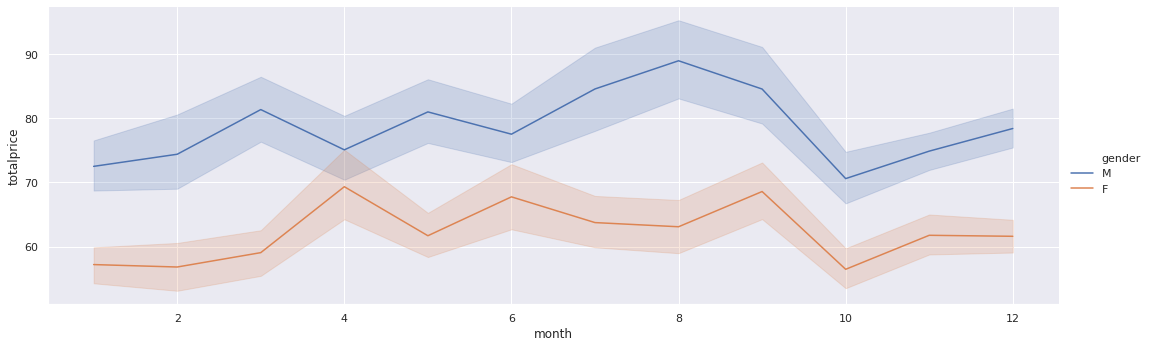

In [81]:
#sezonowość sprzedaży w kolejnych miesiącach z podziałem na płeć
_ = sns.relplot(y = "totalprice", x = "month", data = customers_and_orders,\
                hue = 'gender', kind = "line",aspect = 3)

In [82]:
customers_and_orders_plot = customers_and_orders
customers_and_orders_plot['gender'].replace({"F": "Kobiety","M": "Męższczyźni",}, inplace=True)
fig = px.box(customers_and_orders_plot,x = "month", y = "totalprice",color = 'gender',log_y = True,\
            color_discrete_sequence = px.colors.qualitative.Pastel)
fig.layout.title = 'Rozkład ceny z podziałem na kobiety i męższczyzn w kolejnych miesiącach'
fig.layout.xaxis.title = 'Miesiące'
fig.layout.yaxis.title = "Cena całkowita"
#fig.update_layout(legend_title_text = 'Płeć')
#fig.update_layout( barmode='group')
fig.show()

## Testy statystyczne.

### Test Shapiro-Wilka.

Przy pomocy testu Shapiro-Wilka zbadam czy próba (ilość produktów w jednym zamówieniu) pochodzi z rozkładu normalnego

Przy pomocy testu Shapiro-Wilka możemy przetestować, czy dana próba $X = (x_1, \dots, x_n)$ pochodzi z rozkładu normalnego.
Formułujemy w tym celu hipotezę zerową i hipotezę alternatywną

$H_0$: „dane pochodzą z rozkładu normalnego”.

$H_1$: „dane nie pochodzą z rozkładu normalnego”.

$$\Large W=\frac{(\sum_{i}a_{i}{(n)}({X_{n-i+1}}-X_i))^2}{\sum_{j=1}^{n}(X_j-\overline{X})^2}$$

gdzie:

- $W$ - wynik testu Shapiro-Wilka
- $a_{i}{(n)}$ - stała, wartości w tablicy
- ${(X_{n-i+1}}-X_i)$ - różnica pomiędzy skrajnymi obserwacjami, przy czym i = 1 różnica dla min i max; dla i = 2 różnica dla min+1 i max - 1 itd..
- $j$ - kolejne obserwacje w próbie
- $i$ - kolejne różnice między skrajnymi obserwacjami
- $\overline{X}$ - średnia

Jako miarę istotności wnioskowania, ustalamy poziom istotności $\alpha$ jako maksymalne prawdopodobieństwo popełnienia błędu pierwszego rodzaju, czyli odrzucenia $H_0$ mimo jej prawdziwości. Zazwyczaj przyjmujemy w tym celu wartość $\alpha=0.05$ lub mniejszą.

Wynikiem testu Shapiro-Wilka jest para liczb:
wartość statystyki testowej $W$ i p-wartość $p$, czyli prawdopodobieństwo otrzymania naszych (lub bardziej ekstremalnych) danych z rozkładu normalnego.

Hipotezę zerową możemy odrzucić jeżeli $p<α$.

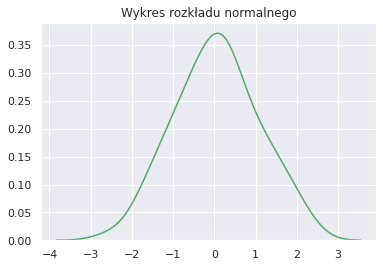

In [83]:
#wykres rozkładu normalnego
sns.set(); np.random.seed(0)
g = np.random.randn(100)
ax = sns.distplot(g, hist=False, color ='g').set(title = "Wykres rozkładu normalnego")

In [0]:
#dane do testu to ilość produktów w jednym zamówieniu
pd.set_option('float_format', '{:.3f}'.format)
test_dane = BigData[[ 'orderid', 'numunits_x']]

test_dane_gr = test_dane.groupby(by = 'orderid').sum()
lista = test_dane_gr['numunits_x'].tolist()

In [85]:
#ponieważ test Shapiro-Wilka sprawda się w próbach N < 500,
#niekiedy w literaturze podawana jest nawet wartość N < 100
#na potrzeby przeprowadzenie testu wybiorę losowo z całej próby 500 przypadków
lista2 = random.sample(lista, 500)
alpha = 0.05
X = lista2

W, p = scipy.stats.shapiro(X)

if (p < alpha) :
  print("p < alpha \nDane nie pochodzą z rozkładu normalnego.")
else :
  print( "Nie można odrzucić hipotezy o normalności rozkładu.")
print("W=",W," ","p=",p)

p < alpha 
Dane nie pochodzą z rozkładu normalnego.
W= 0.31169044971466064   p= 1.9193444936010587e-39


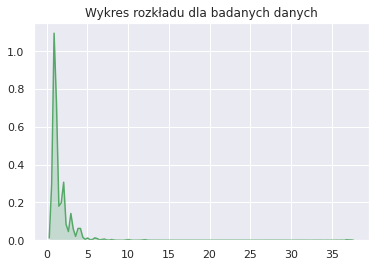

In [86]:
_= sns.kdeplot(lista2, shade=True, color ='g').set(title = "Wykres rozkładu dla badanych danych")

Test potwierdza:
$H_1$: „dane nie pochodzą z rozkładu normalnego”.

### Test Kołmogorowa-Smirnowa. 

Stosowany alternatywnie do testu Shapiro-Wilka przy prubach większych.

Przy pomocy testu Kołmogorowa-Smirnowa możemy przetestować, czy dana próba $X = (x_1, \dots, x_n)$ pochodzi ze wskazanego, znanego rozkładu. Działamy podobnie jak w teście Shapiro-Wilka.

$$\Large K_n = \sup_{x} |(F_{n}-F) (x)|$$

Wynikiem testu Kołmogorowa-Smirnowa jest para liczb:
wartość statystyki testowej $D$ i p-wartość $p$, czyli prawdopodobieństwo otrzymania naszych (lub bardziej ekstremalnych) danych ze wskazanego rozkładu.
Hipotezę zerową możemy odrzucić jeżeli $p<α.$

In [87]:
#dane do testu Kołmogorowa-Smirnowa to wszystkie zamówienie i liczba artykułów w jednym zamówieniu

alpha = 0.05
x = lista
D, p = kstest(x, 'norm', args=(np.mean(x),np.std(x,ddof = 1)))

if (p < alpha) :
  print("Dane nie pochodzą z rozkładu normalnego.")
else :
  print ("Nie można odrzucić hipotezy o normalności rozkładu")
print("D=",D," ","p=",p)

Dane nie pochodzą z rozkładu normalnego.
D= 0.4920948579752706   p= 0.0


### Podsumowanie podsatwowych statystyk 

W przedsiębiorstwie $XXX$ większość klientów, a co za tym idzie zamówień, stanowią mężczyźni. Jest to jednak stosunek około $55$% do $45$%. Największą popularnością cieszą się produkty z grupy $BOOK$ i $ARTWORK$, z których te drugie przynoszą największe zyski dla firmy. Zdecydowanie największą sprzedaż firma $XXX$ posiada w Nowym Jorku, w którym sprzedaż produktów znacznie przewyższa sprzedaż w innych miastach. W $2014$ roku przedsiębiorstwo osiągneło najwyższą sprzedaż a co za tym idzie zyski, które , niestyty, w kolejnych dwóch latach zaczęły spadać. 
Analiza wyników sprzedaży pozwala na wyciąganie wniosków przez zarząd firmy $XXX$ dotyczących m.in.: pracy handlowców i systemów motywacyjnych, produktów, klientów oraz systemu planowania. Analiza struktury klientów jest równie ważna jak analiza produktów. Dzięki niej zarząd może ocenić, którzy klienci najbardziej przyczyniają się do wzrostu poziomu sprzedaży oraz jej rentowności.
Warto zwrócić również uwagę na lokalizacę najwyższej sprzedaży. $Nowy York$ nie jest miastem o wiele większym niż $Los$ $Angeles$ czy $Chicago$. Tym bardziej zastanawiająca jest zatrważająca przewaga w sprzedaży.

## Analiza koszykowa - support, confidence, lift 


Analiza koszykowa służy badaniu powiązań pomiędzy produktami z różnych kategorii.Sprawdzenie czy ktoreś dwa produkty nie powinny być ze sobą powiązane za pomocą promocji lub ułożenia w podobnym miejscu w sklepie, aby zwiększyć sprzedaż.

Wyjaśnienie podstawowych i najważniejszych współczynników w analizie koszykowej.

\textbf{Składnia reguł}

Oznaczam przez PP zbiór produktów $P = {\{P_1, P_2, ..., P_n\}}$
Regułą decyzyjną jest para o strukturze $L \to R$ gdzie obie strony to podzbiory zbioru produktów $L, R \subseteq PL$ (zazwyczaj niewielkie podzbiory).

Typowa interpretacja takiej reguły to: klienci kupujący produkty $LL$ kupują też produkty $RR$.
Par postaci $L \to R$ można wygenerować bardzo wiele. Aby wybrać z nich te użyteczne, wprowadza się kilka miar oceny reguły decyzyjnej.


1. \textbf{Wsparcie reguły (Support)} - jest to odsetek transakcji, które zawierają wybraną regułę. Istotne jest to, że wsparcie jest liczbą z przedziału. Support wyznacza się dla zbioru. Określa do jakiej części transakcji stosuje się dany zbiór. To iloraz liczby transakcji zawierających produkty ze zbioru do liczby wszystkich transakcji.

$$\Large {supp(L)} = \frac{nL}{n}$$

2. \textbf{Zaufanie (Confidence)} - zwane też pewnością reguły, jest to odsetek transkacji zawierających analizowaną regułę w zbiorze tych, które spełniają poprzednik danej reguły. Wielkość ta również należy do przedziału - odpowiada bowiem odpowiedniemu prawdopodobieństwu warunkowemu.

$$\Large{conf(L \to R)} = \frac{supp(L + R)}{supp(L)}$$

3. \textbf{Przyrost/Podniesienie(?) (Lift)} - jest z kolei miarą, która określa nam, czy fakt wystąpienia jednego produktu wpływa na zwiększenie prawdopodobieństwa wystąpienia drugiego w ramach jednej transkacji. Czyli ilukrotnie częściej w transakcjach występuje lewa i prawa strona w stosunku do częstości spodziewanej, gdyby obie strony występowały niezależnie Współczynnik ten jest oczywiście dodatni. 

$$\Large{lift(L \to R)} = \frac{supp(L + R)}{supp(L) supp(R)}$$


Dobra reguła to taka, która ma duże wsparcie (dotyczy wysokiej liczby transakcji) i wiarygodność (prawa strona zachodzi często).

W praktyce często zakłada się minimalne wartości na oba te współczynniki i szuka się wszystkich reguł o wartościach wparcie/wiarygodność wyższych niż założone minimum.

### Przygotowanie danych do analizy koszykowej. 

In [88]:
#wybieram dane do analizy - tabela z pliku orderlines
orderlines_reset = orderlines_raw.reset_index()
orderlines_K = orderlines_reset[['orderid','productid']]
orderlines_K

,orderid,productid
0,1006414,10834
1,1006541,11052
2,1006542,11070
3,1010154,11196
4,1009110,11048
...,...,...
286012,1643154,11012
286013,1643155,13630
286014,1643150,14028
286015,1643156,14028


In [89]:
#druga tabela z pliku products
products_df_reset = products_df.reset_index()
products_df_K = products_df_reset[['productid','productgroupname']]
products_df_K

,productid,productgroupname
0,10001,CALENDAR
1,10002,CALENDAR
2,10003,CALENDAR
3,10004,BOOK
4,10005,BOOK
...,...,...
4035,14036,ARTWORK
4036,14037,ARTWORK
4037,14038,ARTWORK
4038,14039,BOOK


In [90]:
#łączenie wybranych tabel orderlines_K + products_df_K
basket = pd.merge(orderlines_K, products_df_K, left_on = 'productid', right_on = 'productid')

#grupowanie według grupy produktów i numeru zamówienia oraz zliczenie ilości
basket_2 = basket.groupby(['productgroupname','orderid']).count()
basket_2

productid
productgroupname orderid           
APPAREL          1000865          1
                 1001025          1
                 1001027          1
                 1001096          1
                 1001097          1
...                             ...
OTHER            1641184          1
                 1642130          1
                 1642131          1
                 1643139          1
                 1643147          1

[229086 rows x 1 columns]

In [91]:
#tabela pokazująca czy dany produkt był zakupiony z innym
basket_3 = basket_2.unstack().fillna(0).T.astype(int)
basket_3.head()
#niektóre wartości są powyżej 1 ponieważ produkt mógł wystąpić kilkukrotnie podczas jednego zakupu

productgroupname   APPAREL  ARTWORK  BOOK  CALENDAR  FREEBIE  GAME  OCCASION  OTHER
          orderid                                                                  
productid 999992         0        0     1         0        0     0         0      0
          999993         0        0     0         0        0     0         1      0
          999994         0        0     0         0        0     0         1      0
          999995         0        0     0         0        0     0         1      0
          999996         0        0     0         0        0     0         1      0

In [92]:
#tworzę tabelę resetując MultiIndex
basket_4 = basket_3[['APPAREL', 'ARTWORK', 'BOOK', 'CALENDAR', 'FREEBIE', 'GAME', 'OCCASION',
       'OTHER']].reset_index()
basket_4.columns

Index(['level_0', 'orderid', 'APPAREL', 'ARTWORK', 'BOOK', 'CALENDAR', 'FREEBIE', 'GAME', 'OCCASION', 'OTHER'], dtype='object', name='productgroupname')

In [93]:
basket_4

productgroupname,level_0,orderid,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER
0,productid,999992,0,0,1,0,0,0,0,0
1,productid,999993,0,0,0,0,0,0,1,0
2,productid,999994,0,0,0,0,0,0,1,0
3,productid,999995,0,0,0,0,0,0,1,0
4,productid,999996,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
192978,productid,1643153,0,0,0,0,0,3,0,0
192979,productid,1643154,0,0,1,0,0,0,0,0
192980,productid,1643155,0,0,1,0,0,0,0,0
192981,productid,1643156,1,0,0,0,0,0,0,0


In [94]:
basket_5 = basket_4[['APPAREL', 'ARTWORK', 'BOOK', 'CALENDAR', 'FREEBIE', 'GAME', 'OCCASION',
       'OTHER']]
#nakładam makę logiczną (True/False), interesują mnie wartości powyżej 1
flag = basket_5<=1
flag

productgroupname,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER
0,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
192978,True,True,True,True,True,False,True,True
192979,True,True,True,True,True,True,True,True
192980,True,True,True,True,True,True,True,True
192981,True,True,True,True,True,True,True,True


In [95]:
#zmieniam wartości powyżej 1 na 1, wartości 0 zostają nieruszone
#taka operacja jest niezbędna do prawidłowego działania funkcji z biblioteki mlxtend
basket_6 = basket_5.where(flag, (basket_5/basket_5))
basket_6

productgroupname,APPAREL,ARTWORK,BOOK,CALENDAR,FREEBIE,GAME,OCCASION,OTHER
0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
192978,0,0,0,0,0,1,0,0
192979,0,0,1,0,0,0,0,0
192980,0,0,1,0,0,0,0,0
192981,1,0,0,0,0,0,0,0


In [0]:
#jak widać wartości w całej tabeli mają teraz wartość 0 lub 1
#kolumna GAME wiersz 192978 - było 3 (maska - False) jest 1
#lista zakupów jest gotowa do dalszej analizy

### Analiza z użyciem algorytmu apriori do wyznaczenia relacji między produktami

In [97]:
#Sprawdzam częstotliwość występowania różnych kombinacji
#Wykorzystam do tego celu funkcję apriori, z biblioteki mlxtend
freq_items = apriori(basket_6, min_support=0.001, use_colnames=True)
freq_items.head(10)

,support,itemsets
0,0.057,(APPAREL)
1,0.235,(ARTWORK)
2,0.449,(BOOK)
3,0.047,(CALENDAR)
4,0.115,(FREEBIE)
5,0.062,(GAME)
6,0.196,(OCCASION)
7,0.026,(OTHER)
8,0.001,"(APPAREL, ARTWORK)"
9,0.004,"(APPAREL, BOOK)"


In [98]:
#sprawdzam reguły asocjacyjne
#ykorzystam do tego celu drugiej funkcji z biblioteki mlxtend - association_rules
rules = association_rules(freq_items, metric = "confidence", min_threshold=0.0001)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(APPAREL),(ARTWORK),0.057,0.235,0.001,0.022,0.094,-0.012,0.782
1,(ARTWORK),(APPAREL),0.235,0.057,0.001,0.005,0.094,-0.012,0.948
2,(APPAREL),(BOOK),0.057,0.449,0.004,0.066,0.147,-0.022,0.590
3,(BOOK),(APPAREL),0.449,0.057,0.004,0.008,0.147,-0.022,0.951
4,(APPAREL),(FREEBIE),0.057,0.115,0.007,0.116,1.006,0.000,1.001


In [99]:
#wybieramy reguły asocjacyjne
#reguły, do których mamy duże przekonanie - preferujemy confidence, a nie support
plot_conf = rules.sort_values(by = 'confidence', ascending=False).head(50)
plot_conf.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
74,"(OCCASION, OTHER)",(BOOK),0.003,0.449,0.001,0.433,0.966,-0.000,0.973
38,(FREEBIE),(OCCASION),0.115,0.196,0.043,0.373,1.902,0.020,1.283
23,(FREEBIE),(BOOK),0.115,0.449,0.032,0.281,0.627,-0.019,0.767
61,"(BOOK, OCCASION)",(FREEBIE),0.012,0.115,0.003,0.260,2.252,0.002,1.195
41,(OTHER),(FREEBIE),0.026,0.115,0.006,0.238,2.064,0.003,1.161


Powyżesze tabele wskazują, że wystąpienie jednego produktu wpływa na zwiększenie prawdopodobieństwa wystąpienia drugiego w ramach jednego zamówienia. Współczynniki znacznie powyżej 1 obserwujemy w komórkach gdzie występuje produkt $FREEBIE$. Widzimy zatem, że znacząco zwiększamy sprzedaż produktów z kategorii $BOOK$, $OCCASION$ i $OTHER$ dokładając do zamówienia darmowy artykuł.

In [100]:
#wykres prezentujący powiązania pomiędzy produktami
#wsparcie reguły (ang. support) – częstość występowania
#zaufanie (ang. confidence) – pewność reguły
#przyrost (ang/ lift) – ile razy częściej produkty występują razem, niż gdyby były statystycznie niezależne

plot_conf["rule"] = plot_conf["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode") + \
        '->' + plot_conf["consequents"].apply(lambda x: ', '.join(list(x))).astype("unicode")


fig = px.scatter_3d(plot_conf, x = "confidence", y = "lift", z = "support", color = "rule",\
                  color_discrete_sequence=px.colors.qualitative.Pastel)
fig.layout.showlegend=True
fig.show()

### Podsumowanie - Analiza koszykowa 


Analiza koszykowa, to szybka i sprawdzona metoda zwiększenia sprzedaży. Może służyć, do rozplanowania ułożenia towaru na półkach w sklepie, budowy silników rekomendacji w serwisach transakcyjnych, ma też zastosowania w innych zagadnieniach. Produktem może być przeczytana książka, aktywacja genów, proces, na skutek którego następuje uruchomienie działania genu przez akcję określonej cząsteczki aktywującej, obejrzany film czy uruchamianie zależności w doświadczeniach fizycznych.

Jeżeli analiza koszykowa pokaże, że zakup produktu $XYZ$ wpływa na zakup produktu $ABC$, to właściciel sklepu mógłby obniżyć cenę $XYZ$ co zareklamuje sklep jako konkurencyjny i podnieść cenę $ABC$, dzięki czemu koszyk zakupowy jest droższy.

Biblioteka mlxtend, z drugiej strony, dostarcza nam przyjazną implementację metody apriori, i tak długo jak znamy, podstawowe pojęcia, jak $support$, $confidence$ czy też $lift$, znalezienie odpowiednich reguł jest łatwe i szybkie.

## Szeregi czasowe

Szeregi czasowe (time series data) - to ciąg informacji uporządkowanych w czasie, których pomiary wykonywane są z dokładnym krokiem czasowym. Analiza szeregów czasowych obejmuje metody próbujące opisać takie sekwencje danych, a często również wyjaśnić generujące je zjawisko oraz dokonywać prognoz. Prognozowanie w szeregach czasowych polega na wykorzystaniu modelu do predykcji przyszłych zdarzeń w oparciu o zdarzenia przeszłe.

In [101]:
#wyodrębniam dane do analizy szeregu czasowego, informacją uporządkowaną w czasie jest zmienna 'value' (totalprice)
df = orders[['orderdate','totalprice']]
df_1 = df
df.rename(columns={'orderdate':'date'}, inplace=True)
df.rename(columns={'totalprice':'value'}, inplace=True)
df = df.groupby('date').sum()
df

,value
date,
2009-10-04,3346.560
2009-10-05,2519.160
2009-10-06,2729.240
2009-10-07,1279.640
2009-10-08,1126.560
...,...
2016-09-16,723.310
2016-09-17,139.650
2016-09-18,1050.260


In [102]:
df_1 = df.reset_index()
df_1

,date,value
0,2009-10-04,3346.560
1,2009-10-05,2519.160
2,2009-10-06,2729.240
3,2009-10-07,1279.640
4,2009-10-08,1126.560
...,...,...
2536,2016-09-16,723.310
2537,2016-09-17,139.650
2538,2016-09-18,1050.260
2539,2016-09-19,1023.710


In [0]:
#zmieniam nazwę zmiennej na ts (time series) dla jasności
ts = df_1

In [104]:
#Wykres liniowy
#Dysponując wstępnie oczyszczonym zestawem danych możemy przejść do dalszej analizy szeregu czasowego.
#Na początku zastosujemy najbardziej podstawową metodę jaką jest wykres liniowy.
#Wykres liniowy jest dobrym punktem wyjścia do zbadania,
#czy analizowany szereg czasowy charakteryzuje się występowaniem trendu lub wahań cyklicznych.

fig = px.line(ts, x='date', y='value',title = 'Wykres linowy analizowanego szergu czasowego')
fig.layout.xaxis.title = 'Data'
fig.layout.yaxis.title = 'Cena całkowita'
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="miesiąc", step="month", stepmode="backward"),
            dict(count=6, label="1/2 roku", step="month", stepmode="backward"),
            dict(count=3, label="kwartał", step="month", stepmode="backward"),
            dict(count=1, label="rok", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [105]:
#sezonowość miesiące
ts_s= df.resample('M').mean()#.plot(figsize=(15, 6));
ts_ss = ts_s.reset_index()

fig = px.line(ts_ss, x='date', y='value',title = 'Sezonowość miesięczna')
fig.layout.xaxis.title = 'Data'
fig.layout.yaxis.title = 'Cena całkowita'
fig.show()

In [106]:
#Rozkład wartości ceny. W tym celu wykorzystamy wykres pudełkowy. Rozkład miesięczny.

ts2 = ts.reset_index()
ts2 = ts2[['date', 'value']]
ts2 = ts.set_index('date')

monthly = ts2.resample('d').mean()
monthly['month'] = monthly.index.strftime('%B')
monthly = monthly.loc['2010-01-01':'2015-12-31']


fig = px.box(monthly, x='month', y='value', color ='month',\
             title = 'Uśrednione pomiary dzienne w podziale na miesiące')
fig.layout.xaxis.title = 'Miesiąc'
fig.layout.yaxis.title = 'Cena całkowita'
#fig.update_traces(quartilemethod = "exclusive")
#fig.update_layout(legend_title_text = 'Miesiąc')
fig.layout.showlegend = True
fig.show()

In [107]:
#Wiemy, że rozkład zmiennych nie jest rozkładem normalnym, ale dla porządku możemy jeszcze raz narysować histogram.
fig = px.histogram(ts, x="value",nbins=200, marginal="rug",\
                   title = 'Histogram szeregu czasowego')
fig.layout.xaxis.title = 'Cena całkowita'
fig.layout.yaxis.title = 'Ilość'
fig.show()

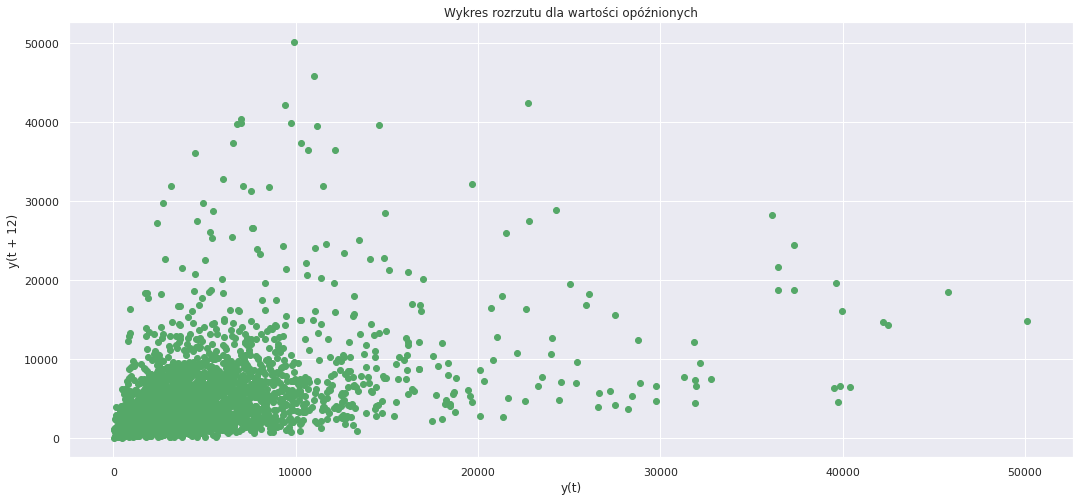

In [108]:
#wykres rozrzutu dla wartości opóźnionych
rcParams['figure.figsize'] = 18, 8
lag_plot(ts['value'], lag=12, c='g')
plt.title('Wykres rozrzutu dla wartości opóźnionych');


Wykres rozrzutu dla wartości opóźnionych pokazuje zależność wartości szeregu w stosunku do wartości z opóźnieniem. Zbór punktów uformowany jest w coś co przypomina chmurę, to znaczy że dane nie są ze sobą skorelowane w silny sposób.

### Funkcja autokorelacji 

Funkcja autokorelacji (ACH) jest uogólnieniem korelacji liniowej Pearsona. Pokazuje ona zależność pomiędzy obserwacjami szeregu czasowego oddalonymi o pewne opóźnienie.

Interpretacja wykresy funkcji autokorelacji jest następująca:

Dodatnie i powoli zanikające wartości funkcji oznacza występowanie trendu,
jeśli funkcja zanika powoli i ma to miejsce w cyklach, to oznacza występowanie sezonowości.

Text(0.5, 1.0, 'Autokorelacja szeregu czasowego')

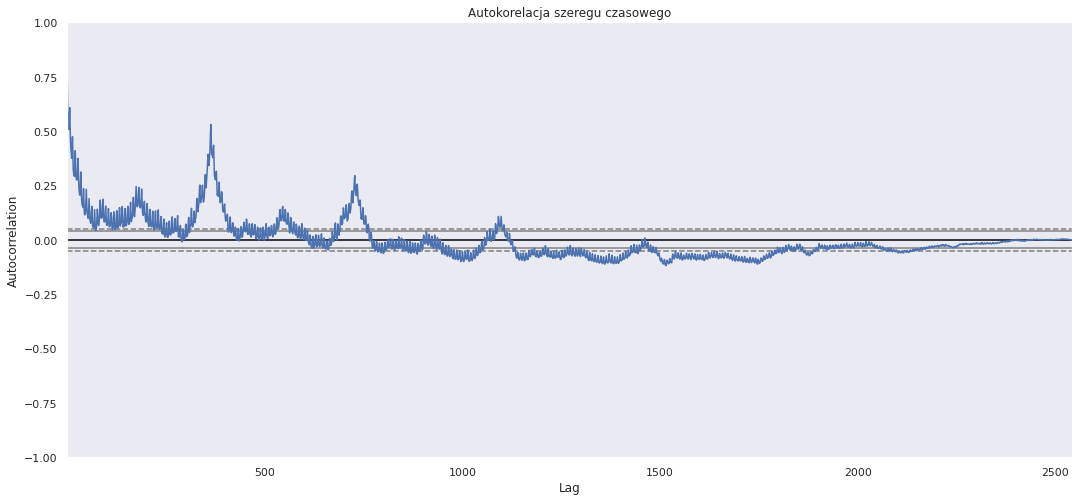

In [109]:
autocorrelation_plot(ts['value'])
plt.title('Autokorelacja szeregu czasowego')

### Dekompozycja szeregu czasowego 

Aby lepiej zrozumieć naturę analizowanego szeregu czasowego, czyli zobaczyć z jaką tendencją mamy do czynienia warto jest rozłożyć go na czynniki pierwsze.

W tym celu stosuje się dekompozycję, czyli wyodrębnienie poszczególnych składowych danego szeregu czasowego, losowych fluktuacji oraz regularnych wzorców w podziale na trend i sezonowość.

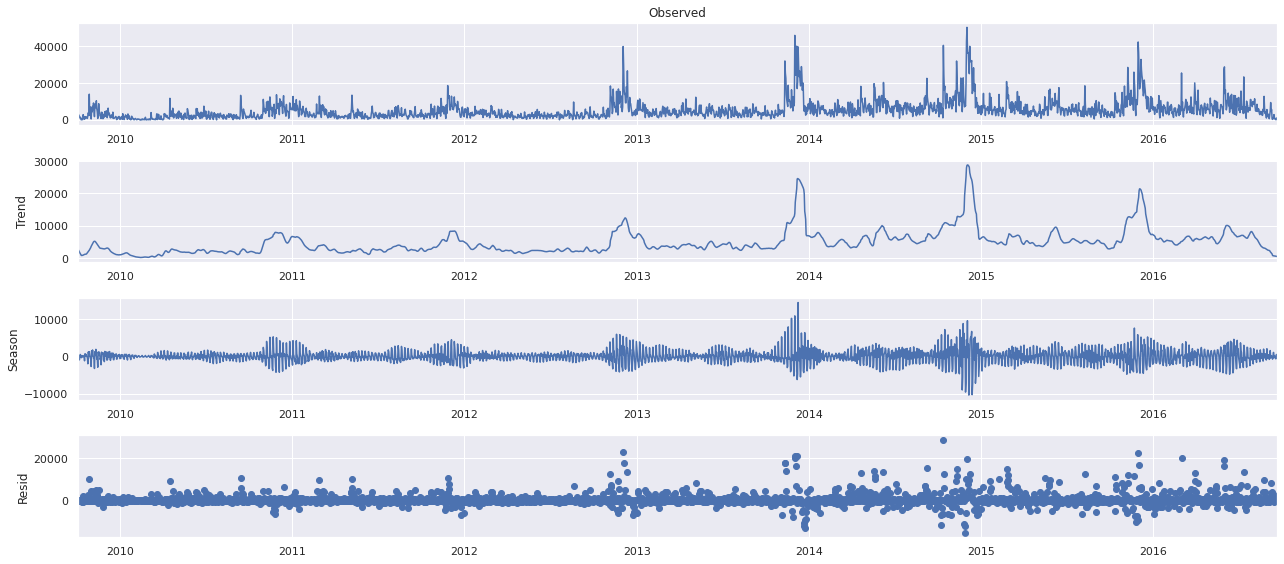

In [110]:
ts2 = ts.set_index('date')
ts2 = ts2 = df.dropna()
ts3 = ts2.resample('D').mean().ffill()

stl = STL(ts3, robust = True).fit()
stl.plot();

W pierwszym oknie widzimy oryginalny kształt wykresu szeregu czasowego. Taki jak na wykresie liniowym na początku.

Kolejne okno prezentuje wyodrębnione informacje dotyczące trendu.

Kolejne okno prezentuje wykres sezonowości.

Ostatni wykres odzwierciedla zjawiska losowe.

### Test Dickeya-Fullera 

$Test Dickeya-Fullera$ pozwala na sprawdzenie czy analizowany szereg czasowy jest stacjonarny.

O stacjonarności szeregu czasowego mówimy, gdy nie stwierdza się w nim trendu, ani sezonowości. Innymi słowy, jego średnia i wariancja nie zmieniają się w czasie. Informacja o stacjonarności jest kluczowa z punktu widzenia doboru modelu prognostycznego.

Interpretacja testu jest następująca, jeśli p-value jest większe od zadanego poziomu istotności, to oznacza to, że szereg czasowy jest niestacjonarny. Najczęściej stosowanym poziomem istotności jest 5%.

In [111]:
X = ts3['value'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.514942
p-value: 0.000185
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### ARIMA, prognozowanie szeregów czasowych

$ARIMA$ oznacza Auto Regressive Integrated Moving Average. Model $ARIMA$ składa się z dwóch części: model autoregresyjny (AR) oraz model średniej ruchomej (moving average MA) i ma trzy zmienne do uwzględnienia:

$ARIMA (p, d, q)$

$p =$ Okresy zwłoki (jeśli P = x, to użyjemy x poprzednich okresów z naszych szeregów czasowych w części autoregresyjnej obliczeń).
$P$ pomaga dostosować dopasowaną linię do prognozowania serii.

$d =$ W modelu ARIMA przekształcamy szereg czasowy w stacjonarny (seria bez trendu lub sezonowości) za pomocą różnicowania.
$D$ oznacza liczbę transformacji różnicowych wymaganych przez szereg czasowy, aby uzyskać stacjonarne.

$q =$ Ta zmienna oznacza opóźnienie komponentu błędu, gdzie komponent błędu jest częścią szeregu czasowego nie wyjaśnionego przez trend lub sezonowość.

#### Różnicowanie szeregu czasowego
Wśród szeregów czasowych rozróżniamy dwa rodzaje procesów stochastycznych: stacjonarne (w których nie występuje trend) oraz niestacjonarne (w których występuje trend). Aby wyeliminować tendencję rozwojową z danego procesu można wykorzystać do tego celu różnicowanie:

$$\Large\Delta y_i = y_i - y_{i-1}$$

Są to po prostu przyrosty, jakie dany szereg osiągał w czasie „i”. Pierwszy poziom różnicowania służy do usunięcia trendu liniowego z szeregu.

In [112]:
#różnicowanie (ang. Differencing)
tsdiff = ts3.diff().dropna()
#tsdiff.plot()

tsdiff_reset_index = tsdiff
fig = px.line(tsdiff_reset_index, y='value',\
              title = 'Wykres linowy analizowanego szergu czasowego poddany różnicowaniu')
fig.show()

#### Funkcje autokorelacji i autokorelacji cząstkowej 

Autokorelacja i autokorelacja cząstkowa to miary związków między bieżącymi i przeszłymi wartościami szeregów określające, które przeszłe wartości szeregów są najbardziej użyteczne przy przewidywaniu przyszłych wartości. Dzięki tej wiedzy można określić kolejność procesów w modelu $ARIMA$. Dokładniej rzecz ujmując:

Funkcja autokorelacji ($ACF$).
- Przy przesunięciu $k$ jest to korelacja między wartościami szeregu oddalonymi o $k$ przedziałów od siebie.

Funkcja autokorelacji cząstkowej ($PACF$).
- Przy przesunięciu $k$ jest to korelacja między wartościami szeregu oddalonymi o $k$ przedziałów od siebie, z jednoczesną rejestracją wartości z przedziałów znajdujących się pomiędzy.

Oś $x$ wykresu $ACF$ wskazuje przesunięcie, dla jakiego obliczana jest autokorelacja; oś $y$ wskazuje wartość korelacji (między $−1$ a $1$). 

Korelacja dodatnia oznacza, że duże wartości bieżące odpowiadają dużym wartościom dla danego przesunięcia; ujemna korelacja oznacza, że duże wartości bieżące odpowiadają niewielkim wartościom dla danego przesunięcia.

Wartość bezwzględna korelacji stanowi miarę siły powiązania, przy czym większe wartości bezwzględne oznaczają silniejsze relacje.

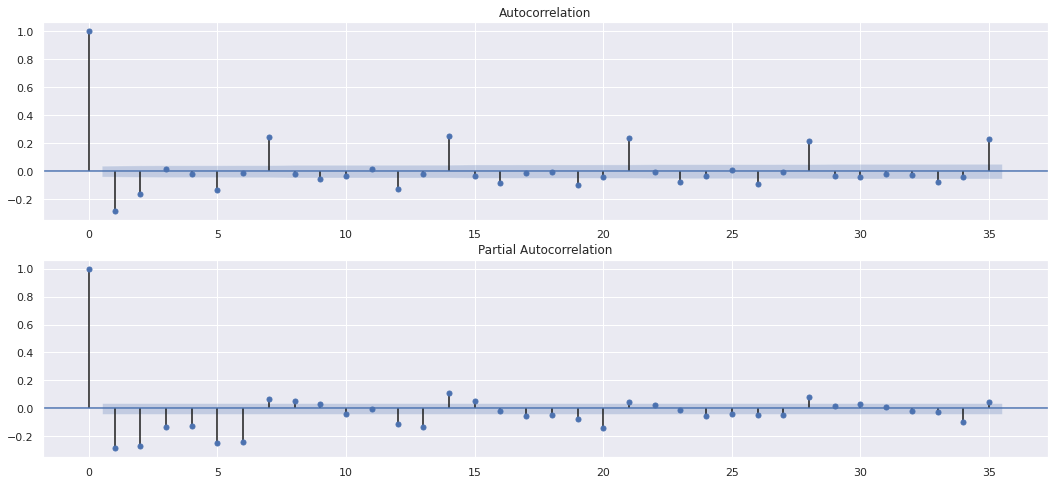

In [113]:
#wykresy autokorelacji i autokorelacji częściowej

plt.figure()
plt.subplot(211)
plot_acf(tsdiff.value, ax=plt.gca())
plt.subplot(212)
plot_pacf(tsdiff.value, ax=plt.gca())
plt.show()

# PARTIAL AUTOCORRELATION PACF - parametr - q
# AUTOCORRELATION ACF - parametr - p

In [0]:
#wyznaczam najleprze wartości dla parametrów p i q do prognozowania
#max_ar - rząd autokorelacji
#max_ma - rząd autokorelacji częściowej
#trend='c' - trend liniowy
results = arma_order_select_ic(tsdiff, max_ar=8, max_ma=8, trend='c', ic=['aic', 'bic'])

In [115]:
#optymalny rząd prognozowania dla parametrów p i q
results.aic_min_order, results.bic_min_order

((8, 8), (8, 8))

In [0]:
#do modelu przekazujemy ts3 - oryginalny szereg czasowy bez zróżnicowania
#parametry order: p i q ustawiam zgodnie z wynikami results.aic_min_order i results.bic_min_order
arima = tsa.arima_model.ARIMA(ts3, order = (8,1,8)).fit()

In [117]:
print(arima.summary())
# interesuje nas kolumna P>|Z|, innymi słowy istotność statystyczna.
#Ważne są tyle te parametry, które mają P>|Z| poniżej 0.05.
#Kolejne parametry ar.L1, ar.L2 itp. odpowiadają rzędom autokorelacji.

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                 2543
Model:                 ARIMA(8, 1, 8)   Log Likelihood              -24077.138
Method:                       css-mle   S.D. of innovations           3126.359
Date:                Thu, 04 Jun 2020   AIC                          48190.277
Time:                        11:16:21   BIC                          48295.416
Sample:                    10-05-2009   HQIC                         48228.414
                         - 09-20-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.4865      0.648      3.837      0.000       1.216       3.757
ar.L1.D.value     0.1581      0.055      2.896      0.004       0.051       0.265
ar.L2.D.value    -0.0533      0.019     

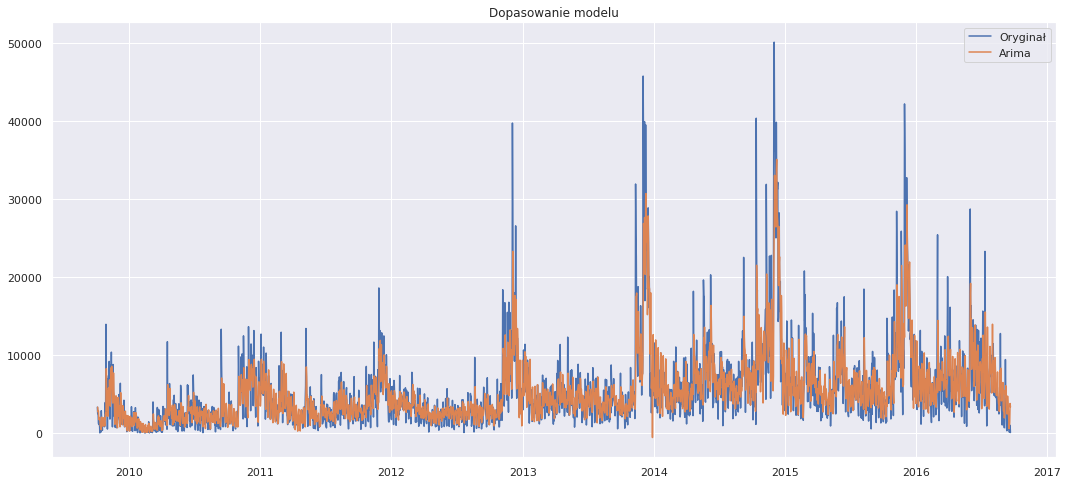

In [118]:
# sprawdzenie dopasowanie wartości
# odwracamy różnicowanie
#typ='levels' - predykcja oryginalych wartości

fitted = arima.predict(typ='levels')
plt.plot(df, label='Oryginał')
plt.plot(fitted, label='Arima')
plt.legend()
plt.title('Dopasowanie modelu')
plt.show()

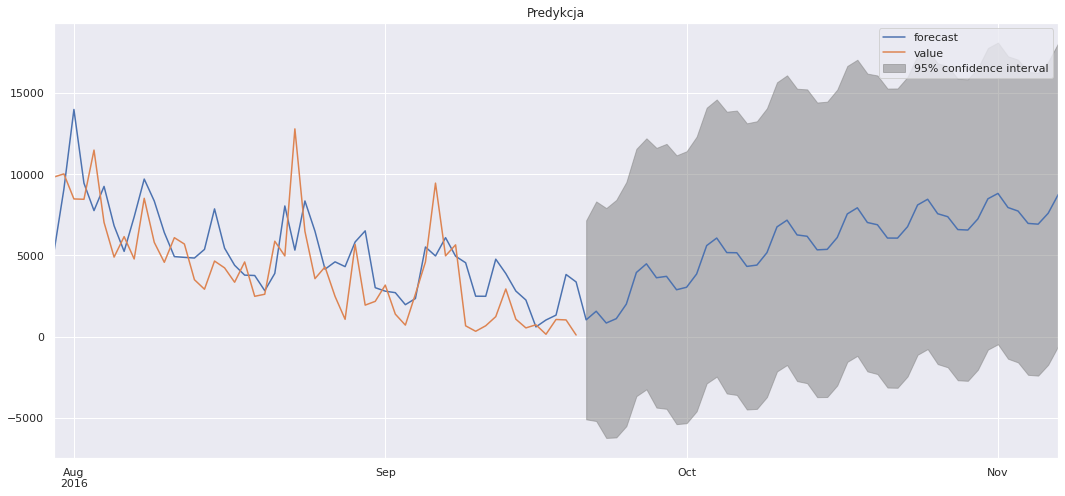

In [119]:
#ostateczna predykcja na wykresie
arima.plot_predict(start = df.shape[0]-50, end = df.shape[0]+50);
plt.title('Predykcja');

#### Podsumowanie - ARIMA
Modele klasy ARIMA są wykorzystywane w wielu sytuacjach prognostycznych. Wykorzystując modele tej klasy do prognozowania szeregów czasowych, można spotkać się z wieloma problemami, m.in. dotyczącymi określenia rzędu różnicowania i rodzaju modelu. Zastosowanie modeli ARIMA nie gwarantuje w każdym przypadku lepszych wyników w porównaniu z otrzymanymi innymi metodami. Mają one jednak tę zaletę, iż wskazują na wewnętrzną strukturę szeregu i objaśniają mechanizm jego generowania. Analiza szeregów za pomocą modeli ARIMA, niesie ze sobą korzyści ze względu na prostą budowę modelu, oraz ciekawą predykcję. Sprawia to, że modelowanie to jest szeroko wykorzystywane w różnych dziedzinach np. ekonomi, medycynie i fizyce. 

### XGBoost

$XGBoost$ (Extreme Gradient Boosting), czyli algorytm wzmacniania gradientowego to obecnie jedna z najpopularniejszych metod z dziedziny data mining, zaproponowana w 2016 roku przez $Tiangi$ $Chen$. 
Algorytm ten jest połączeniem klasycznych drzew decyzyjnych i lasów losowych, zaliczany jest do algorytmów uczenia nadzorowanego, zgodnie z założeniami aby prawidłowo pracował, powinien otrzymać dwa zbiory danych, dane treningowe i dane testowe. Algorytm uczy się znajdować korelacje pomiędzy zmiennymi w kolejnych iteracjach, wykorzystując błędy z poprzednich iteracji. Trzeba pamiętać, że model XGBoost ma postać modelu złożonego i jego fundamentem są drzewa dezyzyjne, XGBoost szkoli wiele drzew a każde kolejne drzewo jest uczone od nowa.

#### Wybór danych do analizy
W analizie dziennych obrotów w przedsiębiorstwie, za pomocą algorytmy XGBoost, wykorzystam dane o obrocie dziennym w kolejnych latach. Dane są indeksowane czasem w odstępach dziennych.

In [120]:
#dane do analizy przy użyciu algorytmu XGBoost
df

,value
date,
2009-10-04,3346.560
2009-10-05,2519.160
2009-10-06,2729.240
2009-10-07,1279.640
2009-10-08,1126.560
...,...
2016-09-16,723.310
2016-09-17,139.650
2016-09-18,1050.260


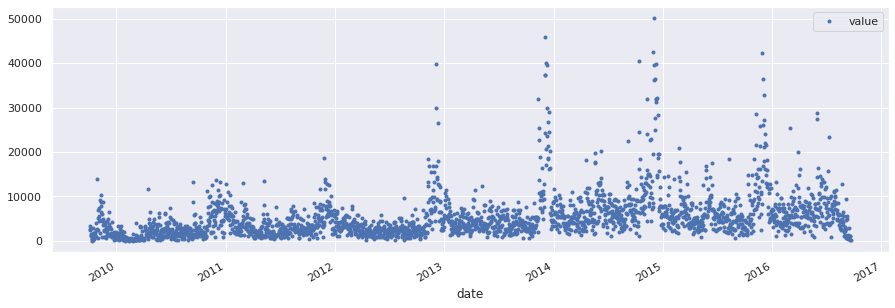

In [121]:
df.plot(style='.', figsize=(15,5));

#### Podział zbioru danych na dane treningowe i testowe.
Ze zbioru dancyh wyodrębniono dane po 1 stycznia 2015 roku. Pozostałe dane wykorzystano do szkolenia modelu z użyciem XGBRegressor.

In [0]:
#podział na dane treningowe i testowe
split_date = '01-Jan-2015'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

(1914, 1)
(627, 1)


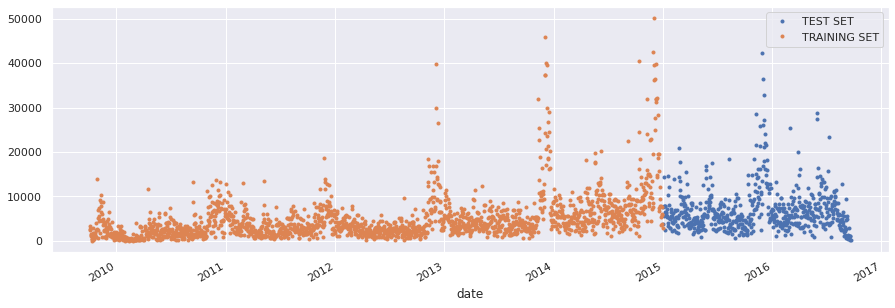

In [123]:
#wykres przedstawiający rozkład danych testowych i treningowych
print(df_train.shape)
print(df_test.shape)

_ = df_test \
    .rename(columns={'value': 'TEST SET'}) \
    .join(df_train.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), style='.')

#### Przygotowanie feature engineering (inżynieria cech). Trenowanie modelu.
$Feature Engineering$ to proces wybierania i przekształcania danych w celu poprawy dokładności algorytmów uczenia maszynowego. Ponieważ dane szeregu czasowego zawierają jedynie dwie zmienne - datę i wartość prognozowaną, tworzenie cech jest bardziej ograniczone.

Dodatkowe cech, które stworzono na bazie daty to:
- kolejny dzień tygodnia
- kwartał (wyodrębnione)
- miesiąc (wyodrębnione)
- rok (wyodrębnione)
- kolejny miesiąc
- kolejny dzień roku
- kolejny tydzień roku

Funkcje obliczające parametry statystyczne przy użycia ruchomego okna, są ważną klasą transformacji tablic używanych do przetwarzania danych szeregu czasowego.
Ze zmiennej $'value'$ stworzono cechy średniej arytmetycznej i odchylenia standardowego z wykorzystaniem funkcji $rolling$, która tworzy obiekt umożliwiający grupowanie o określonym czasie ruchomego okna.

In [0]:
#przygotowanie features
def create_features(df, label=None):
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['MA_7_mean'] = df['value'].rolling(7).mean()
    df['MA_30_mean'] = df['value'].rolling(30).mean()
    df['MA_90_mean'] = df['value'].rolling(90).mean()
    df['MA_200_mean'] = df['value'].rolling(200).mean()
    df['MA_7_std'] = df['value'].rolling(7).std()
    df['MA_30_std'] = df['value'].rolling(30).std()
    df['MA_90_std'] = df['value'].rolling(90).std()
    df['MA_200_std'] = df['value'].rolling(200).std()
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','MA_7_mean',
            'MA_30_mean','MA_90_mean','MA_200_mean','MA_7_std',
            'MA_30_std','MA_90_std','MA_200_std'
            ]]
    if label:
        y = df[label]
        return X, y

    return X

In [125]:
#przygotowanie danych do modelu
X_train, y_train = create_features(df_train, label='value')
X_test, y_test = create_features(df_test, label='value')

print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

X_train: (1914, 15)
y_train: (1914,)
X_test: (627, 15)
y_test: (627,)


In [126]:
reg = xgb.XGBRegressor(n_estimators=1000, max_depth = 5, )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[11:16:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### Istotność cech. Dopasowanie modelu do wartości rzeczywistych.

Jak można zauważyć najbardziej istotne cech, które mają duży wpływ na uczenie modelu to odchylenie standardowe z oknem 7 dniowym, kolejny dzień tygodnia i średnia arytmetyczna wartości z oknem 7 dniowym.
Najmniej istotnę cechy uzyskane w części gdzie zajmowaliśmy się inżynierią cech, to miesiąc, kwartał i kolejny tydzień roku.

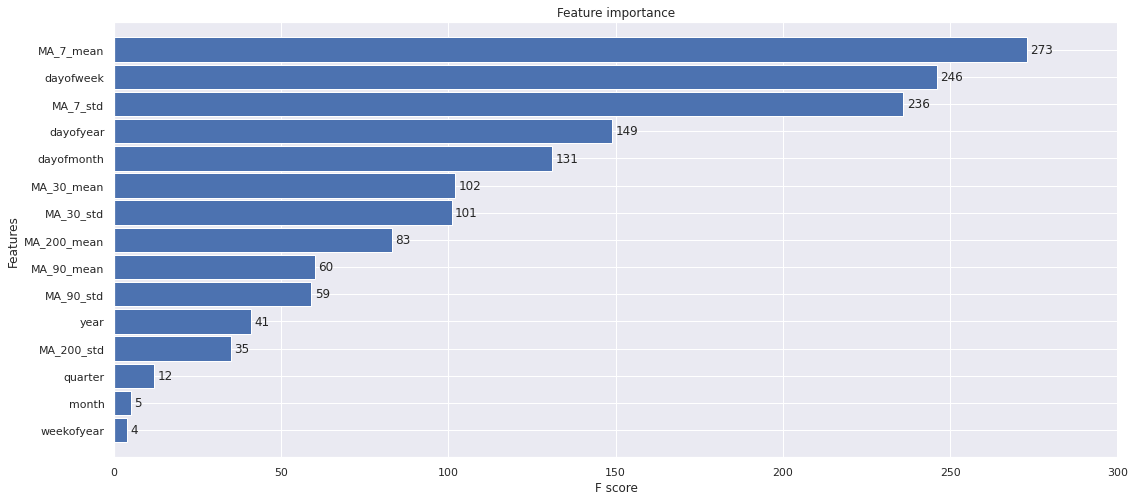

In [127]:
#wykres rzedstawiający istotne cechy
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plot_importance(reg, height=0.9);

In [0]:
df_test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

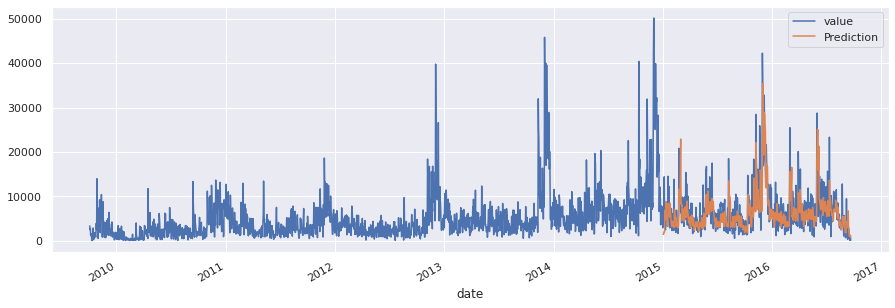

In [129]:
#wykres przedstawiający dopasowanie modelu
df_all[['value','Prediction']].plot(figsize=(15, 5));

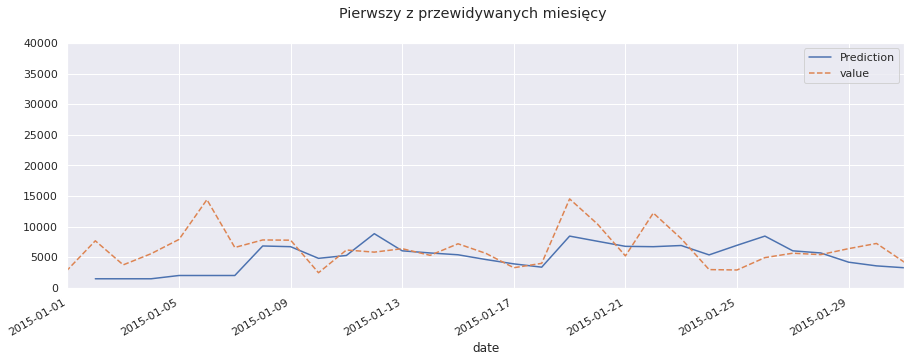

In [130]:
#wykres przedstawiający pierwszy z przewidywanych miesięcy
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','value']].plot(ax=ax,
                                              style=['-','--'])
ax.set_ylim(0, 40000)
ax.set_xbound(lower='01-01-2015', upper='01-31-2015')
plot = plt.suptitle('Pierwszy z przewidywanych miesięcy')

#### Określenie błędów modelu.

Prognozując zjawiska ekonomiczno-biznesowe, będące wynikiem działań człowieka, jesteśmy skazani na błędne prognozy.
Mierników do wyboru jest bardzo wiele. O ile istnieje jedna definicja błędu pojedynczej prognozy, będąca różnicą miedzy realizacją a prognozą, o tyle istnieje wiele miar, które „uśredniają” błędy z wielu prognoz na różne sposoby. Do najpopularniejszych należą:

Podstawową miarą pomiaru błędu między miarą prognozowaną a prognozą jest, błąd oznaczany jako $e$ (error). Jest to różnica/odchylenie między zmienną prognozowaną a jej prognozą.
$$\Large e_t = {y_t - y_t^p}$$
gdzie:
- $y_t$ to zmienna prognozowana
- $y_t^p$ to prognoza

Jest to podstawowa miara błędu dla okresu $t$.
$$\Large t = 1,2,3,...,n$$

- (Pierwiastkowy) Błąd średniokwadratowy - RMSE
$$\Large RMSE=\sqrt{\frac{1}{n}\sum_{t=1}^{n}e_t^2}$$
- Średni błąd absolutny - MAE
$$\Large MAE=\frac{1}{n}\sum_{t=1}^{n}|e_t|$$
- Średni procentowy błąd prognozy - MAPE
$$\Large MAPE=\frac{100\%}{n}\sum_{t=1}^{n}\left |\frac{e_t}{y_t}\right|$$

MAE, RMSE, MAPE: zawsze musi być dodatnie, im mniejsza wartość, tym lepiej.
Interpretacja:
MAE, RMSE: o ile przeciętnie mylimy się, prognozując z modelu.
MAPE: o ile procent przeciętnie mylimy się, prognozując z modelu.

In [131]:
#wyliczenie średniej kwadratowej błędów,czyli pierwiastka kwaratowego z MSE. -  root mean square error
#miara różnic między wartościami przewidywanymi przez model lub estymator a obserwowanymi wartościami
print('RMSE error is:', mean_squared_error(y_true=df_test['value'],
                   y_pred=df_test['Prediction']))

RMSE error is: 14879485.85001419


In [132]:
#średni błąd bezwzględny MAE (mean absolute error), informuje on o ile średnio w okresie prognoz,
#będzie wynosić odchylenie od wartości rzeczywistej.
#Czyli, krótko mówiąc, o jakim błędem miarowym jest obarczona nasza prognoza.

print('MAE error is:',mean_absolute_error(y_true=df_test['value'],
                   y_pred=df_test['Prediction']))


MAE error is: 2543.263112138812


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [134]:
#Średni bezwzględny błąd procentowy MAPE (mean absolute percentage error)
#informuje on o średniej wielkości błędów prognoz dla okresu testowego,
#wyrażonych w procentach.
#Wartość MAPE pozwala na porównanie dokładność prognoz różnych modeli.

print('MAPE error is:', mean_absolute_percentage_error(y_true=df_test['value'],
                   y_pred=df_test['Prediction']))

MAPE error is: 48.37630944112459


Jak widać procentowy błąd wynosi aż 46.33, jest to zdecydowanie za dużo aby brać pod uwagę prognozowanie jako element planowania. Choć z drugiej strony może to być dobry punkt wyjścia do dalszych analiz i budowania modelu ML gdzie wyniki blędów będą mniejsze.

#### Tabele przedstawiające porównanie wartości rzeczywistej i przewydzianej z błędami predykcji.

In [0]:
df_test['error'] = df_test['value'] - df_test['Prediction']
#abs - wartość bezwzględna błędu
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['value','Prediction','error','abs_error']]

In [136]:
#prognozowane dni
error_by_day.sort_values('error', ascending=True).head(10)

value  Prediction      error  abs_error
year month dayofmonth                                            
2015 3     2           6470.530   22892.141 -16421.611  16421.611
2016 6     3           8598.820   24921.689 -16322.869  16322.869
2015 12    3          16874.680   28938.674 -12063.994  12063.994
2016 3     5           1616.450   12923.810 -11307.360  11307.360
           7           5464.940   16529.150 -11064.210  11064.210
2015 11    25          2388.790   13236.544 -10847.754  10847.754
2016 6     1          14315.930   25096.834 -10780.904  10780.904
           4           5465.900   15982.610 -10516.710  10516.710
           6          10724.900   21237.660 -10512.760  10512.760
2015 11    24          5985.560   15212.308  -9226.748   9226.748

In [137]:
#dni najgorzej przewidziane
error_by_day.sort_values('abs_error', ascending=False).head(10)

value  Prediction      error  abs_error
year month dayofmonth                                            
2015 11    30         42226.940   16172.310  26054.630  26054.630
           8          28462.680    6726.948  21735.732  21735.732
           21         25908.010    6370.581  19537.429  19537.429
     3     2           6470.530   22892.141 -16421.611  16421.611
2016 6     3           8598.820   24921.689 -16322.869  16322.869
2015 11    22         21308.300    7769.292  13539.008  13539.008
     1     6          14399.150    2004.343  12394.807  12394.807
     12    6          32773.130   20666.383  12106.747  12106.747
           3          16874.680   28938.674 -12063.994  12063.994
     11    1          18370.200    6486.398  11883.802  11883.802

Jak widać dniem z największym błędem prognozy przewidywanej ceny jest 8 listopad 2015 roku. Błąd wynosi aż 22393.92. Jest to oczywiście niedopuszczalna różnica. 

In [138]:
# dni najlepiej przewidziane
error_by_day.sort_values('abs_error', ascending=True).head(10)

value  Prediction   error  abs_error
year month dayofmonth                                        
2016 4     6          7560.100    7555.220   4.880      4.880
2015 2     10         6855.950    6843.297  12.653     12.653
     7     20         6296.430    6281.645  14.785     14.785
2016 4     29         5231.290    5254.453 -23.163     23.163
2015 10    24         3121.850    3097.794  24.056     24.056
           20         6010.240    6034.762 -24.522     24.522
     6     22         5463.440    5495.031 -31.591     31.591
     5     1          2274.350    2235.594  38.756     38.756
     11    17         8445.150    8405.866  39.284     39.284
     4     1          4049.800    4090.609 -40.809     40.809

Dniem, który miał najmniejszy błąd prognozowania, jest 19.09.2016. Błąd wynosi zaledwie 7.4.
Ponożej przedstawiam jeszcse wykresy dla tych dwóch dni. Wartość rzeczywista i wartość prognozowana.

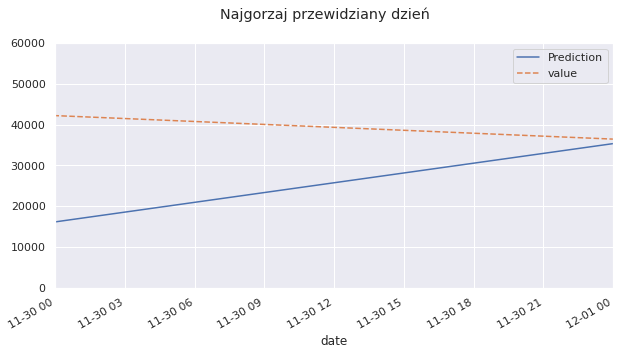

In [139]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['Prediction','value']].plot(ax=ax,
                                              style=['-','--'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='11-30-2015', upper='12-01-2015')
plot = plt.suptitle('Najgorzaj przewidziany dzień')

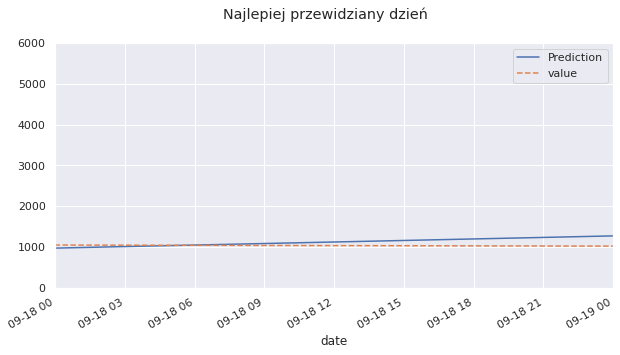

In [140]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['Prediction','value']].plot(ax=ax,
                                              style=['-','--'])
ax.set_ylim(0, 6000)
ax.set_xbound(lower='09-18-2016', upper='09-19-2016')
plot = plt.suptitle('Najlepiej przewidziany dzień')

___________________________________________________________________________________________________________________

## Zakończenie.

Analiza danych danego przedsiębiorstwa pozwoliła na spojrzenie z wielu perspektyw na problemy z jakimi firma może się zmierzyć a jednocześnie pokazuje jak wiele możliwości otwiera analiza danych z wykorzystaniem uczenie maszynowego.

Jak można zauważyć analiza szeregów czasowych, czy to za pomocą modelu $ARIMA$ czy za pomocą algorytmu $XGBoost$, pozwala na wyciągnięcie wniosków, które mogą być pomocne w rozwoju przedsiębiorstwa, doborze strategii sprzedażowej i poprawie wyników sprzedażowych. Marketing to dynamicznie zmieniający się obszar, który wymaga ciągłego monitorowania sytuacji. Dostosowanie się do obecnej sytuacji jest niezbędne, aby cały czas zwiększać grupę odbiorców. Technologie oparte na sztucznej inteligencji oraz algorytmy uczenia maszynowego są właśnie tym, co może usprawnić ten proces. Prognozowanie sprzedaży i wyników firmy pozwala nam zdecydować, jaką strategię marketingową zastosować. Prognozowanie oparte na $AI$ pozwoli nam określić priorytet zadań i zdecydować, na jakich działaniach lub kanałach należy się skupić w danym momencie, jakie obszary dział marketingu powiniem brać pod uwagę w szególności, mając na uwadze przyszłe zyski firmy. Uczenie maszynowe umożliwia coraz lepiej spersonalizowaną rekomendację produktów w postaci reklam, jak również kierowanie reklam do konkretnego odbiorcy, wykorzystując media społecznościowe i reklamy cyfrowe, komunikat zostanie przedstawiony osobom, które rzeczywiście są nim zainteresowane. Wszystkie te działania mogą znacząco poprawić relacje marki z klientami i podnieść skuteczność działań marketingowych.

___________________________________________________________________________________________________________________